<a href="https://colab.research.google.com/github/matidav/Bitcoin-Stocks-Correlation-Project/blob/main/545_Project_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS545 Fall 2021 Final Project

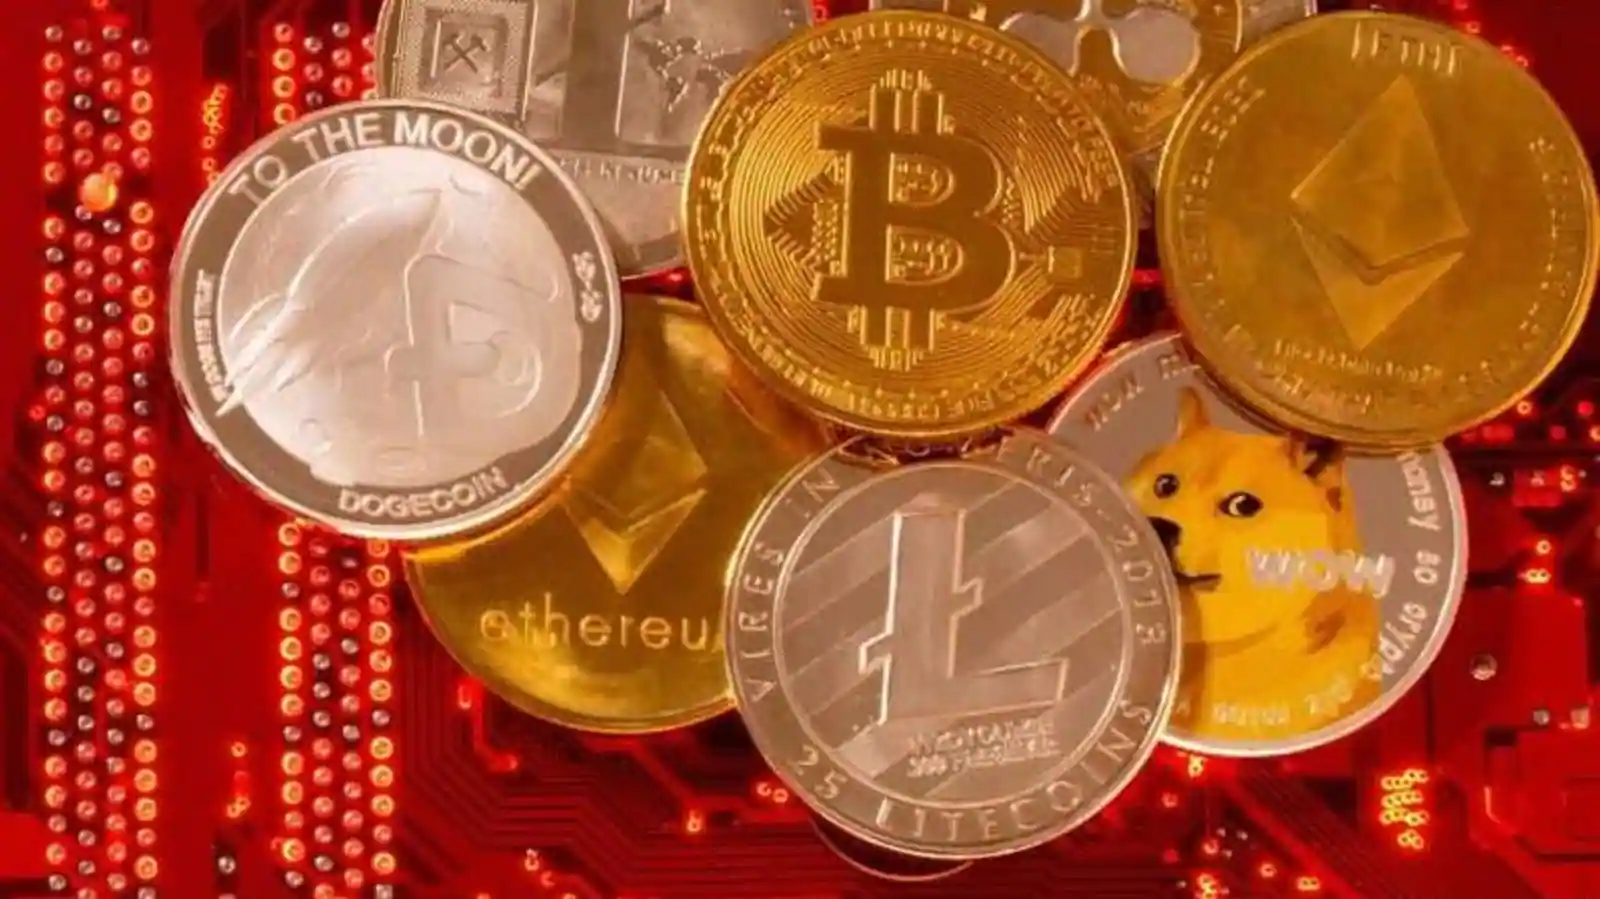

## **Introduction**
Group Member: Xinwei Tang, Winston Kuo, Mati Davis

### **Cryptocurrency**
Cryptocurrency is first introduced in 2008 after the financial crisis. As crypto emerges in the current market, it is hot debated whether there is a correlation between cryptocurrency and the stock market. Since the cryptocurrency trading market was only developed in recent years, there are not a lot of trading strategies involved in cryptocurrencies. However, since cryptocurrency is a mean of financial investment like stocks, we wonder **if the trading strategies of stocks can be implemented on cryptocurrencies**. 

### **Objective**
We want to discover the relationship between stock and cryptocurrency prices through different models, and determine if the trading strategy for stocks can be applied to cryptocurrencies.

We will predict the prices of cryptocurrency with the stock price, and calculate accuracy. If the prediction has high accuracy, the trading strategy that predict stock prices may be applied on **predicting the price movement of cryptocurrencies**.

### **Deliverables**


*   Annotated Google Colab Notebook
*   [Google Slides Presentation](https://drive.google.com/file/d/1IupZELvKGlTM0PHoAqUzDAVsCcRCzFV6/view?usp=sharing)



### **Selection of data**

We have selected S&P 500 Index as the data to find correlation between stock prices and cryptocurrency prices. S&P 500 is one of the most commonly followed equity index by financial institutions around globe. It tracks the performance of 500 large companies listed on stock exchange in the United States. 

However, S&P 500 only includes the largest companies, it may not give a holistic indication of correlation between stocks and cryptocurrencies. Therefore, we also included the data set of all S&P 500 stocks.

We are using the data for price movement of cryptocurrency from **2013 to 2018**.

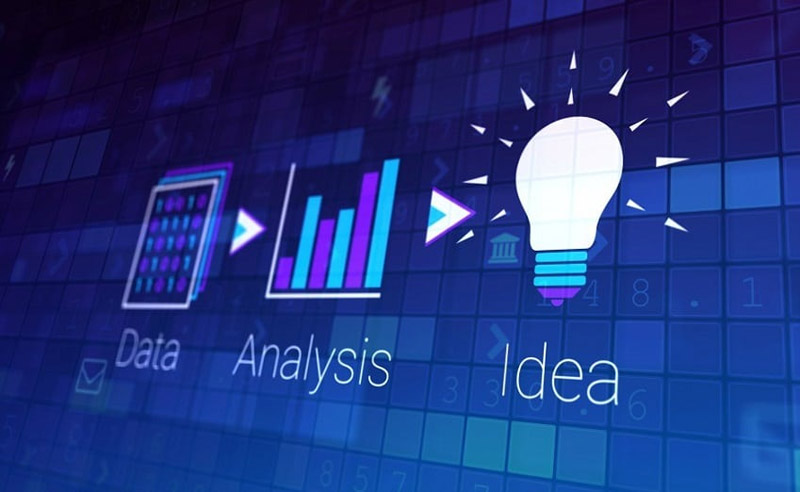

## Data download
The 3 excel data files below are required if users want to run the colab notebook on their end.
Below are the links that will be necessary throughout the notebook.                
S&P 500 stock data: [all_stocks_5yr](https://www.kaggle.com/camnugent/sandp500)                              
S&P 500 Index: [spx](https://www.kaggle.com/pdquant/sp500-daily-19862018)                              
Cryptocurrency: [crypto-markets](https://www.kaggle.com/jessevent/all-crypto-currencies) 

Importing the majority of the libraries used are the ones we learned during class, such as pandas, NumPy, seaborn, sklearn, pyspark.

In [ ]:
import pandas as pd
import numpy as np 
!pip install pandasql
import pandasql as ps
import json
from datetime import datetime
import glob
import seaborn as sns
import re
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

In [ ]:
#sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import sklearn.metrics

In [ ]:
#sparkML
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libkrb5-dev is already the newest version (1.16-2ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
--2021-12-14 21:44:36--  https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 135.181.214.104, 2a01:4f8:10a:201a::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228834641 (218M) [application/x-gzip]
Saving to: ‘spark-3.1.2-bin-hadoop3.2.tgz.1’

spark-3.1.2-bin-had 100%[===================>] 218.23M  10.3MB/s    in 24s     

2021-12-14 21:45:01 (9.05 MB/s) - ‘spark-3.1.2-bin-hadoop3.2.tgz.1’ saved [228834641/228834641]



# **1. Reading data**


### **1.1 Crypto Data**
This data set consists of approximately 100,000 rows of records, which keeps track of the price of different kinds of cryptos from 2013 to 2018.
Features includes:

1. symbol, name, slug: This is the name of the crypto

2. ranknow: This is the rank of the crypto by popularity

3. open/close: The price when market open and close

4. high/low: The highest and lowest price of the day

5. date: The date of that record

6. volume: Trading volume of the day

7. market: Market capitalization

8. close_ratio: Indicator of the ratio of successful trades

9. spread: Difference between the highest bid offer and the lowest ask offer



In [ ]:
## Read crypto data
crypto_df = pd.read_csv('crypto-markets.csv')
crypto_df.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.0,1.488567e+09,0.5438,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.0,1.603769e+09,0.7813,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.0,1.542813e+09,0.3843,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.0,1.298955e+09,0.2882,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.0,1.168517e+09,0.3881,33.32


### **1.2 S&P 500 Index Price**
This data set consists of approximately 8,000 rows of records, which keeps track of the stock price index from 2013 to 2018.
Features includes:

1. date: The date of that record

2. close: The price when market close


In [ ]:
## read index data
index_df = pd.read_csv('spx.csv')
index_df.head()

,date,close
0,02-Jan-86,209.59
1,03-Jan-86,210.88
2,06-Jan-86,210.65
3,07-Jan-86,213.80
4,08-Jan-86,207.97


### **1.3 S&P 500 Stock Price Data**
This data set consists of approximately 600,000 rows of records, which keeps track of the stock price information from 2013 to 2018.
Features includes:

1. date: The date of that record

2. ranknow: This is the rank of the crypto by popularity

3. open/close: The price when market open and close

4. high/low: The highest and lowest price of the day

5. volume: Number of shares traded

6. Name: Name of the company


In [ ]:
## read stock data
stock_df = pd.read_csv('all_stocks_5yr.csv')
stock_df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


# **2. Data Cleaning**

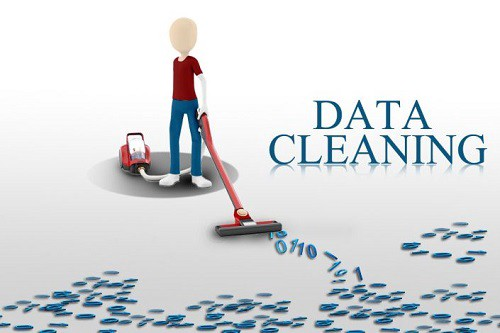

In this section, we will perform data cleaning. We aim to retain useful data from the dataframes above, while at the same time, add potentially useful columns as features that will be used by models later on.

We have summaized the cleaning procedures as follows:

### Crypto
1. Remove unuseful columns and rows (Remove unpopular crypto)
2. Add a column for % change of price compared to the previous day
3. Add a column for average % change for all crypto on that day.
4. Rename columns to make them unique for later join

### S&P 500 Index
1. Add a column for % change of price compared to the previous day
2. Rename columns to make them unique for later join

### S&P 500 Stocks
1. Remove unuseful columns.
2. Add a column for % change of price compared to the previous day
3. Add a column for 5 days moving average.
4. Add columns for average % change for close price and 5 days moving average
5. Rename columns to make them unique for later join

### Aggregate Data
1. Join all three sets of data based on dates

## **2.1 Data cleaning for Cryptocurrency**

In [ ]:
# working on crypto
crypto_df.head(5)

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.0,1.488567e+09,0.5438,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.0,1.603769e+09,0.7813,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.0,1.542813e+09,0.3843,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.0,1.298955e+09,0.2882,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.0,1.168517e+09,0.3881,33.32


##### Rank and the Stock Price
Notice that currently the data have a column called "ranknow", which refers to the popularity of the crypto type, and it also has the closing price. We want to see if that the higher the rank, the higher the closing price. For simplicity, we will just check if there is a correlation by using the data in 2018.

If the correlation is insignificant, this column is not useful and will not be included in the features.

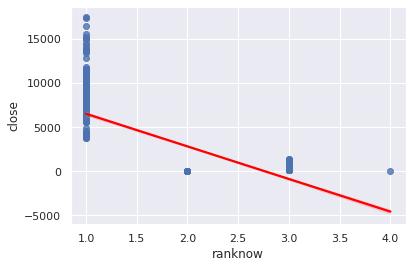

In [ ]:
rankPrice2018 = crypto_df.loc[crypto_df['date'].str.contains("2018", case=False)]
sns.set(color_codes = True)

rankVSprice = sns.regplot(x="ranknow", y="close", data = rankPrice2018.head(1000),line_kws={'color':'red'})


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


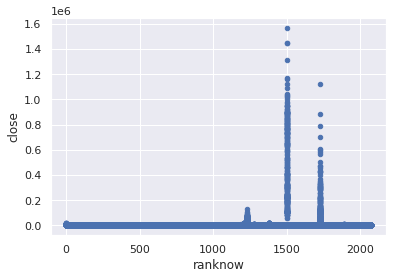

In [ ]:
rankPrice2018.plot(kind = 'scatter', x='ranknow', y='close')

Now we can use heat map to see the relations among all features

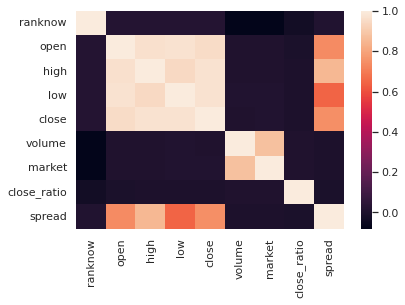

In [ ]:
crypto_df_corr = crypto_df.corr()
sns.heatmap(crypto_df_corr)

In [ ]:
crypto_df.dtypes

slug            object
symbol          object
name            object
date            object
ranknow          int64
open           float64
high           float64
low            float64
close          float64
volume         float64
market         float64
close_ratio    float64
spread         float64
dtype: object

ranknow has no correlation with any other data. Therefore, it will not be included in the features later on.

Here, we are identifying the unuseful features to drop. 

'slug' column is dropped because it essentially contains the same information as 'name'.

In machine learning for financial data, the common practice is to use or compare the closing price of the day for learning. This is because the price movement like 'high', 'low', are not final prices of the day, and has no timestamp associated with it. On the other hand, the closing price is the final price of the day.

'open' is also dropped because S&P 500 Index does not have opening index data to compare with it. 

'volume' is not useful in our analysis, since we are investigating the correlation between price movements. So we dropped it. Same for columns that exhibits similar irrelevance like 'market', 'close_ratio' and 'spread'. 

In [ ]:
# drop unuseful columns
crypto_df_drop = crypto_df.drop(columns = ['slug', 'open', 'high', 'low', 'volume', 'market', 'close_ratio', 'spread'])
crypto_df_drop.head(5)

,symbol,name,date,ranknow,close
0,BTC,Bitcoin,2013-04-28,1,134.21
1,BTC,Bitcoin,2013-04-29,1,144.54
2,BTC,Bitcoin,2013-04-30,1,139.00
3,BTC,Bitcoin,2013-05-01,1,116.99
4,BTC,Bitcoin,2013-05-02,1,105.21


#### Percentage change

We will be adding columns representing the percentage change in price movements. This column can be useful in comparing the percentage change in prices for index and stocks later on.

In [ ]:
# add column for percentage change
crypto_df_drop['c_change'] = crypto_df_drop['close'].pct_change()
crypto_df_drop.head(5)

,symbol,name,date,ranknow,close,c_change
0,BTC,Bitcoin,2013-04-28,1,134.21,NaN
1,BTC,Bitcoin,2013-04-29,1,144.54,0.076969
2,BTC,Bitcoin,2013-04-30,1,139.00,-0.038328
3,BTC,Bitcoin,2013-05-01,1,116.99,-0.158345
4,BTC,Bitcoin,2013-05-02,1,105.21,-0.100692




 **'crypto_df_filtered'** consist data that we deemed useful for learning by human judgement. 
.

We are adding the avergae price price per day as a column, to see if the average price is correlated to stocks or index. 

In [ ]:
#get average crypto price per day
crypto_df['avg'] = crypto_df['low'] + (crypto_df['high'] - crypto_df['low'])/2 
crypto_df

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,avg
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.0,1.488567e+09,0.5438,3.88,134.040
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.0,1.603769e+09,0.7813,13.49,140.745
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.0,1.542813e+09,0.3843,12.88,140.490
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.0,1.298955e+09,0.2882,32.17,123.805
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.0,1.168517e+09,0.3881,33.32,108.940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942292,project-x,NANOX,Project-X,2018-11-26,1727,22424.60,23049.30,17607.50,20724.80,143.0,1.622000e+03,0.5728,5441.80,20328.400
942293,project-x,NANOX,Project-X,2018-11-27,1727,20711.90,23742.10,19292.90,23298.70,637.0,1.823000e+03,0.9003,4449.20,21517.500
942294,project-x,NANOX,Project-X,2018-11-28,1727,23320.90,25235.10,19888.10,24442.70,49.0,1.913000e+03,0.8518,5347.00,22561.600
942295,project-x,NANOX,Project-X,2018-11-29,1727,24543.53,24582.47,21457.95,22839.44,153.0,1.788000e+03,0.4421,3124.52,23020.210


In [ ]:
#add column for percentage change to full
crypto_df['c_change'] = crypto_df['close'].pct_change()
crypto_df['o_change'] = crypto_df['open'].pct_change()
crypto_df['avg_change'] = crypto_df['avg'].pct_change()
crypto_df.head(5)

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,avg,c_change,o_change,avg_change
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.0,1.488567e+09,0.5438,3.88,134.040,NaN,NaN,NaN
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.0,1.603769e+09,0.7813,13.49,140.745,0.076969,-0.006356,0.050022
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.0,1.542813e+09,0.3843,12.88,140.490,-0.038328,0.071110,-0.001812
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.0,1.298955e+09,0.2882,32.17,123.805,-0.158345,-0.034722,-0.118763
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.0,1.168517e+09,0.3881,33.32,108.940,-0.100692,-0.162734,-0.120068



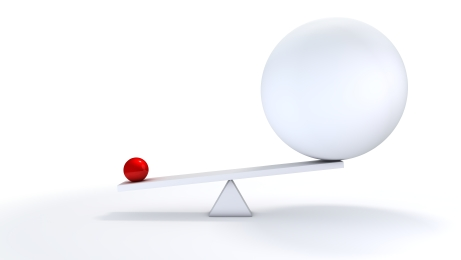


There are thousands of cryptocurrencies, many of them are **extremely unpopular** and will not be considered as means of investment. So we think the unpopular cryptocurrencies should be dropped from the dataframe. In addition, those cryptocurrencies **exhibits low trading volume and market capitalization**. So it is unfair to assign them equal significance as large cryptocurrencies like Bitcoin. 

Therefore, we will **only retain the top 100** largest cryptocurrencies in the dataframes. 

In [ ]:
# drop unpopular cryptos
crypto_df_filtered = crypto_df_drop[crypto_df_drop['ranknow'] <= 100]
crypto_df_filtered_full = crypto_df[crypto_df['ranknow'] <= 100]

In [ ]:
crypto_df_filtered.tail()

,symbol,name,date,ranknow,close,c_change
67415,MCO,Crypto.com,2018-11-25,100,2.23,0.072115
67416,MCO,Crypto.com,2018-11-26,100,2.07,-0.071749
67417,MCO,Crypto.com,2018-11-27,100,2.03,-0.019324
67418,MCO,Crypto.com,2018-11-28,100,2.26,0.113300
67419,MCO,Crypto.com,2018-11-29,100,2.30,0.017699


In [ ]:
#crypto_df_filtered_full.tail()

Finding the average price change for the top 100 cryptocurrencies, to represent the overall price movement of the cryptocurrency market. 

In [ ]:
# Average of change on each day
c_query = '''
SELECT date, AVG(c_change) AS c_avg_change
FROM crypto_df_filtered
GROUP BY date
'''

crypto_df_avg = ps.sqldf(c_query, locals())

In [ ]:
# Average of change on each day for full df
c_full_query = '''
SELECT date, AVG(c_change) AS c_avg_change, AVG(o_change) as o_avg_change, AVG(avg_change) as avg_avg_change 
FROM crypto_df_filtered_full
GROUP BY date
'''

crypto_df_avg_full = ps.sqldf(c_full_query, locals())

In [ ]:
crypto_df_avg.head()

,date,c_avg_change
0,2013-04-28,0.440397
1,2013-04-29,0.041933
2,2013-04-30,-0.028297
3,2013-05-01,-0.137312
4,2013-05-02,-0.106925


In [ ]:
crypto_df_avg_full.head()

,date,c_avg_change,o_avg_change,avg_avg_change
0,2013-04-28,0.440397,0.306991,0.377207
1,2013-04-29,0.041933,0.004961,0.037832
2,2013-04-30,-0.028297,0.038987,-0.004315
3,2013-05-01,-0.137312,-0.029861,-0.108581
4,2013-05-02,-0.106925,-0.140807,-0.112699


In [ ]:
# change column names and drop ranknow column
crypto_df_final = crypto_df_drop.rename(columns={'symbol':'c_symbol', 'name':'c_name', 'close':'c_close'}).drop(columns=['ranknow'])
crypto_df_full_final = crypto_df.rename(columns={'symbol':'c_symbol', 'name':'c_name', 'open': 'c_open', 'avg': 'c_avg', 'close':'c_close'}).drop(columns=['ranknow'])


In [ ]:
crypto_df_final

,c_symbol,c_name,date,c_close,c_change
0,BTC,Bitcoin,2013-04-28,134.21,NaN
1,BTC,Bitcoin,2013-04-29,144.54,0.076969
2,BTC,Bitcoin,2013-04-30,139.00,-0.038328
3,BTC,Bitcoin,2013-05-01,116.99,-0.158345
4,BTC,Bitcoin,2013-05-02,105.21,-0.100692
...,...,...,...,...,...
942292,NANOX,Project-X,2018-11-26,20724.80,-0.076048
942293,NANOX,Project-X,2018-11-27,23298.70,0.124194
942294,NANOX,Project-X,2018-11-28,24442.70,0.049101
942295,NANOX,Project-X,2018-11-29,22839.44,-0.065593


In [ ]:
#crypto_df_full_final

#### Exclusive dataframe for Bitcoin

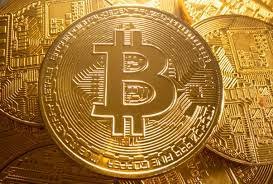

Bitcoin is the most popular cryptocurrency with **highest liquidity**. In the hope of getting more insights, we think it is interesting to investigate the correlation of price movement of Bitcoin against stocks. Since S&P 500 have the most popular stocks with high liquidity, we think it makes sense to compare them with crytocurrency with the highest liquidity.

This also makes sense in the objective of portfolio management. For stock investments, investors mitigate risk by diversifying portfolio through investing stocks from different industries. However, **cryptocurrencies currently cannot be classified by industries**. Cryptocurrencies are **much more indifferent than stocks**, and have much more speculative sentiments. Therefore, investors have little incentive to invest in a huge number of crytocurrencies. Instead, they want to invest in a few major cryptocurrencies with the highest liquidities, so they can execute timely exit strategies.

Therefore, we will create the dataframes that only exhibits the data for Bitcoin below.

In [ ]:
# data only for BTC
crypto_df_BTC = crypto_df_final[crypto_df_final['c_symbol']=='BTC']
crypto_df_BTC['bit_change'] = crypto_df_BTC['c_change']
crypto_df_BTC


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,c_symbol,c_name,date,c_close,c_change,bit_change
0,BTC,Bitcoin,2013-04-28,134.21,NaN,NaN
1,BTC,Bitcoin,2013-04-29,144.54,0.076969,0.076969
2,BTC,Bitcoin,2013-04-30,139.00,-0.038328,-0.038328
3,BTC,Bitcoin,2013-05-01,116.99,-0.158345,-0.158345
4,BTC,Bitcoin,2013-05-02,105.21,-0.100692,-0.100692
...,...,...,...,...,...,...
2037,BTC,Bitcoin,2018-11-25,4009.97,0.033295,0.033295
2038,BTC,Bitcoin,2018-11-26,3779.13,-0.057567,-0.057567
2039,BTC,Bitcoin,2018-11-27,3820.72,0.011005,0.011005
2040,BTC,Bitcoin,2018-11-28,4257.42,0.114298,0.114298


In [ ]:
# data only for BTC full df
crypto_df_full_BTC = crypto_df_full_final[crypto_df_full_final['c_symbol']=='BTC']
crypto_df_full_BTC['bit_c_change'] = crypto_df_full_BTC['c_change']
crypto_df_full_BTC['bit_o_change'] = crypto_df_full_BTC['o_change']
crypto_df_full_BTC['bit_avg_change'] = crypto_df_full_BTC['avg_change']
crypto_df_full_BTC

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,slug,c_symbol,c_name,date,c_open,high,low,c_close,volume,market,close_ratio,spread,c_avg,c_change,o_change,avg_change,bit_c_change,bit_o_change,bit_avg_change
0,bitcoin,BTC,Bitcoin,2013-04-28,135.30,135.98,132.10,134.21,0.000000e+00,1.488567e+09,0.5438,3.88,134.040,NaN,NaN,NaN,NaN,NaN,NaN
1,bitcoin,BTC,Bitcoin,2013-04-29,134.44,147.49,134.00,144.54,0.000000e+00,1.603769e+09,0.7813,13.49,140.745,0.076969,-0.006356,0.050022,0.076969,-0.006356,0.050022
2,bitcoin,BTC,Bitcoin,2013-04-30,144.00,146.93,134.05,139.00,0.000000e+00,1.542813e+09,0.3843,12.88,140.490,-0.038328,0.071110,-0.001812,-0.038328,0.071110,-0.001812
3,bitcoin,BTC,Bitcoin,2013-05-01,139.00,139.89,107.72,116.99,0.000000e+00,1.298955e+09,0.2882,32.17,123.805,-0.158345,-0.034722,-0.118763,-0.158345,-0.034722,-0.118763
4,bitcoin,BTC,Bitcoin,2013-05-02,116.38,125.60,92.28,105.21,0.000000e+00,1.168517e+09,0.3881,33.32,108.940,-0.100692,-0.162734,-0.120068,-0.100692,-0.162734,-0.120068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,bitcoin,BTC,Bitcoin,2018-11-25,3880.78,4120.87,3585.06,4009.97,6.825640e+09,6.974927e+10,0.7930,535.81,3852.965,0.033295,-0.107393,-0.061197,0.033295,-0.107393,-0.061197
2038,bitcoin,BTC,Bitcoin,2018-11-26,4015.07,4107.14,3643.92,3779.13,6.476900e+09,6.573929e+10,0.2919,463.22,3875.530,-0.057567,0.034604,0.005857,-0.057567,0.034604,0.005857
2039,bitcoin,BTC,Bitcoin,2018-11-27,3765.95,3862.96,3661.01,3820.72,5.998720e+09,6.646897e+10,0.7908,201.95,3761.985,0.011005,-0.062046,-0.029298,0.011005,-0.062046,-0.029298
2040,bitcoin,BTC,Bitcoin,2018-11-28,3822.47,4385.90,3822.47,4257.42,7.280280e+09,7.407256e+10,0.7720,563.43,4104.185,0.114298,0.015008,0.090963,0.114298,0.015008,0.090963


In [ ]:
# average % change of cryto on each day
crypto_query = '''
SELECT date, AVG(c_change) as c_change_avg
FROM crypto_df_final
GROUP BY date
'''
crypto_df_aggregate = ps.sqldf(crypto_query, locals())
crypto_df_aggregate.head()

,date,c_change_avg
0,2013-04-28,68.845105
1,2013-04-29,0.089292
2,2013-04-30,-0.023004
3,2013-05-01,-0.151730
4,2013-05-02,-0.107047


In [ ]:
# average % change of cryto on each day for full df
crypto_full_query = '''
SELECT date, AVG(c_change) as c_change_avg, AVG(o_change) as o_change_avg, AVG(avg_change) as avg_change_avg
FROM crypto_df_full_final
GROUP BY date
'''
crypto_full_df_aggregate = ps.sqldf(crypto_full_query, locals())
crypto_full_df_aggregate.head()

,date,c_change_avg,o_change_avg,avg_change_avg
0,2013-04-28,68.845105,67.254523,67.583014
1,2013-04-29,0.089292,0.002578,0.055983
2,2013-04-30,-0.023004,0.081839,0.036200
3,2013-05-01,-0.151730,-0.021604,-0.117243
4,2013-05-02,-0.107047,-0.150841,-0.113502


## **2.2 Data Cleaning for S&P 500 Index**

In [ ]:
# Add a column representing daily percentage change
index_df_change = index_df.copy()
index_df_change['i_change'] = index_df_change['close'].pct_change()
index_df_change.head()

,date,close,i_change
0,02-Jan-86,209.59,NaN
1,03-Jan-86,210.88,0.006155
2,06-Jan-86,210.65,-0.001091
3,07-Jan-86,213.80,0.014954
4,08-Jan-86,207.97,-0.027268


In [ ]:
index_df_change.dtypes

date         object
close       float64
i_change    float64
dtype: object

In [ ]:
# change date format
index_df_change['date'] = pd.to_datetime(index_df_change['date'])
#index_df_change['date'].dt.striftime('%Y-%m-%d')
index_df_change

,date,close,i_change
0,1986-01-02,209.59,NaN
1,1986-01-03,210.88,0.006155
2,1986-01-06,210.65,-0.001091
3,1986-01-07,213.80,0.014954
4,1986-01-08,207.97,-0.027268
...,...,...,...
8187,2018-06-25,2717.07,-0.013725
8188,2018-06-26,2723.06,0.002205
8189,2018-06-27,2699.63,-0.008604
8190,2018-06-28,2716.31,0.006179


## **2.3 Data Cleaning for stocks**

In [ ]:
# working on stock data
stock_df

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


In [ ]:
# drop unuseful columns
stock_df_drop = stock_df.drop(columns=['open', 'high', 'low', 'volume'])
stock_df_drop.head(5)

,date,close,Name
0,2013-02-08,14.75,AAL
1,2013-02-11,14.46,AAL
2,2013-02-12,14.27,AAL
3,2013-02-13,14.66,AAL
4,2013-02-14,13.99,AAL


In [ ]:
# add column for % change
stock_df_change = stock_df_drop.copy()
stock_df_change['s_change'] = stock_df_change['close'].pct_change()
stock_df_change.head(5)

,date,close,Name,s_change
0,2013-02-08,14.75,AAL,NaN
1,2013-02-11,14.46,AAL,-0.019661
2,2013-02-12,14.27,AAL,-0.013140
3,2013-02-13,14.66,AAL,0.027330
4,2013-02-14,13.99,AAL,-0.045703


In [ ]:
#add avg stock price column for each day to full dataframe
stock_df['avg'] = stock_df['low'] + (stock_df['high'] - stock_df['low'])/2

In [ ]:
# add columns for % change for full dataframe
stock_df_full_change = stock_df.copy()
stock_df_full_change['s_c_change'] = stock_df_full_change['close'].pct_change()
stock_df_full_change['s_o_change'] = stock_df_full_change['open'].pct_change()
stock_df_full_change['s_avg_change'] = stock_df_full_change['avg'].pct_change()
stock_df_full_change.head(5)

,date,open,high,low,close,volume,Name,avg,s_c_change,s_o_change,s_avg_change
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,14.875,NaN,NaN,NaN
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,14.635,-0.019661,-0.011944,-0.016134
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,14.305,-0.013140,-0.029550,-0.022549
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,14.595,0.027330,-0.010381,0.020273
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,14.060,-0.045703,0.044755,-0.036656


In [ ]:
stock_df_change.iloc[[1]][['date']]

,date
1,2013-02-11


In [ ]:
stock_df_change.iloc[:,3]

0              NaN
1        -0.019661
2        -0.013140
3         0.027330
4        -0.045703
            ...   
619035    0.014206
619036   -0.013364
619037   -0.038421
619038   -0.007585
619039    0.008052
Name: s_change, Length: 619040, dtype: float64

#### Moving average

Since stock prices are also influenced by company-specific news, we can smoothen the data by implementing 5 days moving average for the percentage price changes. This can reduce the influence of outlier events that cause unnatural changes in prices. 

In [ ]:
# implement 5 days moving average (SMA = Simple Moving Average)
short_df = stock_df_change.copy()
short_df['SMA_5'] = short_df.iloc[:, 1].rolling(window=5).mean() # weekly
short_df

,date,close,Name,s_change,SMA_5
0,2013-02-08,14.75,AAL,NaN,NaN
1,2013-02-11,14.46,AAL,-0.019661,NaN
2,2013-02-12,14.27,AAL,-0.013140,NaN
3,2013-02-13,14.66,AAL,0.027330,NaN
4,2013-02-14,13.99,AAL,-0.045703,14.426
...,...,...,...,...,...
619035,2018-02-01,77.82,ZTS,0.014206,78.434
619036,2018-02-02,76.78,ZTS,-0.013364,77.772
619037,2018-02-05,73.83,ZTS,-0.038421,76.702
619038,2018-02-06,73.27,ZTS,-0.007585,75.686


In [ ]:
# implement 5 days moving average for full
short_full_df = stock_df_full_change.copy()
short_full_df['SMA_c_5'] = short_full_df.iloc[:, 4].rolling(window=5).mean() # weekly
short_full_df['SMA_o_5'] = short_full_df.iloc[:, 1].rolling(window=5).mean() # weekly
short_full_df['SMA_avg_5'] = short_full_df.iloc[:, 7].rolling(window=5).mean() # weekly
short_full_df

,date,open,high,low,close,volume,Name,avg,s_c_change,s_o_change,s_avg_change,SMA_c_5,SMA_o_5,SMA_avg_5
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,14.875,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,14.635,-0.019661,-0.011944,-0.016134,NaN,NaN,NaN
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,14.305,-0.013140,-0.029550,-0.022549,NaN,NaN,NaN
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,14.595,0.027330,-0.010381,0.020273,NaN,NaN,NaN
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,14.060,-0.045703,0.044755,-0.036656,14.426,14.730,14.494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS,77.480,0.014206,-0.021022,-0.002254,78.434,78.614,78.544
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS,77.425,-0.013364,0.008980,-0.000710,77.772,78.222,78.078
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS,75.050,-0.038421,-0.011479,-0.030675,76.702,77.588,77.182
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS,73.345,-0.007585,-0.050887,-0.022718,75.686,76.448,76.191


In [ ]:
short_df['SMA_5_change'] = short_df['SMA_5'].pct_change()
short_df.head(10)

,date,close,Name,s_change,SMA_5,SMA_5_change
0,2013-02-08,14.75,AAL,NaN,NaN,NaN
1,2013-02-11,14.46,AAL,-0.019661,NaN,NaN
2,2013-02-12,14.27,AAL,-0.013140,NaN,NaN
3,2013-02-13,14.66,AAL,0.027330,NaN,NaN
4,2013-02-14,13.99,AAL,-0.045703,14.426,NaN
5,2013-02-15,14.50,AAL,0.036455,14.376,-0.003466
6,2013-02-19,14.26,AAL,-0.016552,14.336,-0.002782
7,2013-02-20,13.33,AAL,-0.065217,14.148,-0.013114
8,2013-02-21,13.37,AAL,0.003001,13.890,-0.018236
9,2013-02-22,13.57,AAL,0.014959,13.806,-0.006048


In [ ]:
short_full_df['SMA_c_5_change'] = short_full_df['SMA_c_5'].pct_change()
short_full_df['SMA_o_5_change'] = short_full_df['SMA_o_5'].pct_change()
short_full_df['SMA_avg_5_change'] = short_full_df['SMA_avg_5'].pct_change()
short_full_df.head(10)

,date,open,high,low,close,volume,Name,avg,s_c_change,s_o_change,s_avg_change,SMA_c_5,SMA_o_5,SMA_avg_5,SMA_c_5_change,SMA_o_5_change,SMA_avg_5_change
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,14.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,14.635,-0.019661,-0.011944,-0.016134,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,14.305,-0.013140,-0.029550,-0.022549,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,14.595,0.027330,-0.010381,0.020273,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,14.060,-0.045703,0.044755,-0.036656,14.426,14.730,14.494,NaN,NaN,NaN
5,2013-02-15,13.93,14.61,13.93,14.50,15628000,AAL,14.270,0.036455,-0.067604,0.014936,14.376,14.502,14.373,-0.003466,-0.015479,-0.008348
6,2013-02-19,14.33,14.56,14.08,14.26,11354400,AAL,14.320,-0.016552,0.028715,0.003504,14.336,14.390,14.310,-0.002782,-0.007723,-0.004383
7,2013-02-20,14.17,14.26,13.15,13.33,14725200,AAL,13.705,-0.065217,-0.011165,-0.042947,14.148,14.334,14.190,-0.013114,-0.003892,-0.008386
8,2013-02-21,13.62,13.95,12.90,13.37,11922100,AAL,13.425,0.003001,-0.038814,-0.020430,13.890,14.198,13.956,-0.018236,-0.009488,-0.016490
9,2013-02-22,13.57,13.60,13.21,13.57,6071400,AAL,13.405,0.014959,-0.003671,-0.001490,13.806,13.924,13.825,-0.006048,-0.019298,-0.009387


In [ ]:
# Add column for average % change
stocks_avg_query = '''
SELECT date, AVG(s_change) AS s_change_avg
FROM short_df
GROUP BY date
'''
stocks_df_avg = ps.sqldf(stocks_avg_query, locals())
stocks_df_avg.head()

,date,s_change_avg
0,2013-02-08,0.014266
1,2013-02-11,-0.001137
2,2013-02-12,0.002904
3,2013-02-13,0.001617
4,2013-02-14,0.000336


In [ ]:
# # Add column for average % change for full df
stocks_full_avg_query = '''
SELECT date, AVG(s_c_change) AS s_c_change_avg, AVG(s_o_change) AS s_o_change_avg, AVG(s_avg_change) AS s_avg_change_avg
FROM short_full_df
GROUP BY date
'''
stocks_full_df_avg = ps.sqldf(stocks_full_avg_query, locals())
stocks_full_df_avg.head()

,date,s_c_change_avg,s_o_change_avg,s_avg_change_avg
0,2013-02-08,0.014266,0.004088,0.003393
1,2013-02-11,-0.001137,0.003947,0.000983
2,2013-02-12,0.002904,0.000210,0.001863
3,2013-02-13,0.001617,0.003561,0.002513
4,2013-02-14,0.000336,-0.003214,-0.001454


In [ ]:
# Add column for change in % for average 5 days
stocks_avg_query_sma = '''
SELECT date, AVG(SMA_5_change) AS sma_5_change_avg
FROM short_df
GROUP BY date
'''
stocks_df_avg_sma = ps.sqldf(stocks_avg_query_sma, locals())
stocks_df_avg_sma.head()

,date,sma_5_change_avg
0,2013-02-08,-0.007645
1,2013-02-11,-0.045166
2,2013-02-12,-0.063901
3,2013-02-13,-0.098621
4,2013-02-14,-0.152719


In [ ]:
# # Add column for change in % for average 5 days for full df
stocks_full_avg_query_sma = '''
SELECT date, AVG(SMA_c_5_change) AS sma_c_5_change_avg, AVG(SMA_o_5_change) AS sma_o_5_change_avg, AVG(SMA_avg_5_change) AS sma_avg_5_change_avg
FROM short_full_df
GROUP BY date
'''
stocks_full_df_avg_sma = ps.sqldf(stocks_full_avg_query_sma, locals())
stocks_full_df_avg_sma.head()

,date,sma_c_5_change_avg,sma_o_5_change_avg,sma_avg_5_change_avg
0,2013-02-08,-0.007645,-0.008775,-0.008310
1,2013-02-11,-0.045166,-0.047611,-0.046684
2,2013-02-12,-0.063901,-0.071057,-0.068331
3,2013-02-13,-0.098621,-0.092340,-0.094701
4,2013-02-14,-0.152719,-0.153447,-0.154463


In [ ]:
# Joining 2 df above
join_query = '''
SELECT ss.date,sa.s_change_avg, ss.sma_5_change_avg
FROM stocks_df_avg_sma AS ss
JOIN stocks_df_avg AS sa
ON ss.date = sa.date
'''
stocks_df_final = ps.sqldf(join_query, locals())
stocks_df_final.head()

,date,s_change_avg,sma_5_change_avg
0,2013-02-08,0.014266,-0.007645
1,2013-02-11,-0.001137,-0.045166
2,2013-02-12,0.002904,-0.063901
3,2013-02-13,0.001617,-0.098621
4,2013-02-14,0.000336,-0.152719


In [ ]:
# # Joining 2 df above for full df
join_full_query = '''
SELECT ss.date, sa.s_c_change_avg, ss.sma_c_5_change_avg, sa.s_o_change_avg, ss.sma_o_5_change_avg, sa.s_avg_change_avg, ss.sma_avg_5_change_avg
FROM stocks_full_df_avg_sma AS ss
JOIN stocks_full_df_avg AS sa
ON ss.date = sa.date
'''
stocks_full_df_final = ps.sqldf(join_full_query, locals())
stocks_full_df_final.head()

,date,s_c_change_avg,sma_c_5_change_avg,s_o_change_avg,sma_o_5_change_avg,s_avg_change_avg,sma_avg_5_change_avg
0,2013-02-08,0.014266,-0.007645,0.004088,-0.008775,0.003393,-0.008310
1,2013-02-11,-0.001137,-0.045166,0.003947,-0.047611,0.000983,-0.046684
2,2013-02-12,0.002904,-0.063901,0.000210,-0.071057,0.001863,-0.068331
3,2013-02-13,0.001617,-0.098621,0.003561,-0.092340,0.002513,-0.094701
4,2013-02-14,0.000336,-0.152719,-0.003214,-0.153447,-0.001454,-0.154463


## 2.4 Merging all dataframes

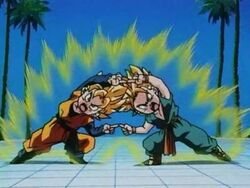

In this section, we will merge all dataframes that we created for cryptocurrency, S&P 500 Index, and stocks. The merged dataframe will be used for models later on.

Remember that for each type of data, we have 2 dataframes. One dataframe that only include features that we deemed useful, and one that includes all features. **We will only merge dataframes in the same category**. 

#### **2.4.1 Joining cryptocurrency data with stocks data**

In [ ]:
# ultra join for all useful df
super_query = '''
SELECT cdf.date, cdf.c_change_avg, sdf.s_change_avg, sdf.sma_5_change_avg
FROM crypto_df_aggregate AS cdf
JOIN stocks_df_final AS sdf
ON cdf.date = sdf.date
'''

final_df = ps.sqldf(super_query, locals())
final_df


,date,c_change_avg,s_change_avg,sma_5_change_avg
0,2013-04-29,0.089292,0.006691,0.004577
1,2013-04-30,-0.023004,0.004380,0.003036
2,2013-05-01,-0.151730,-0.009892,0.000609
3,2013-05-02,-0.107047,0.009683,0.001268
4,2013-05-03,12.778635,0.012610,0.004616
...,...,...,...,...
1200,2018-02-01,-0.086016,-0.002452,-0.002430
1201,2018-02-02,0.018199,-0.020146,-0.008356
1202,2018-02-05,-0.188501,-0.036907,-0.014138
1203,2018-02-06,0.181230,0.013354,-0.009497


In [ ]:
# # ultra join for all useful df for full df
super_full_query = '''
SELECT cdf.date, cdf.c_change_avg, cdf.o_change_avg, cdf.avg_change_avg, sdf.s_c_change_avg, sdf.s_o_change_avg, sdf.s_avg_change_avg, sdf.sma_c_5_change_avg, sdf.sma_o_5_change_avg, sdf.sma_avg_5_change_avg
FROM crypto_full_df_aggregate AS cdf
JOIN stocks_full_df_final AS sdf
ON cdf.date = sdf.date
'''

final_full_df = ps.sqldf(super_full_query, locals())
final_full_df

,date,c_change_avg,o_change_avg,avg_change_avg,s_c_change_avg,s_o_change_avg,s_avg_change_avg,sma_c_5_change_avg,sma_o_5_change_avg,sma_avg_5_change_avg
0,2013-04-29,0.089292,0.002578,0.055983,0.006691,0.000183,0.003544,0.004577,0.004228,0.004875
1,2013-04-30,-0.023004,0.081839,0.036200,0.004380,0.003017,0.002060,0.003036,0.003348,0.002987
2,2013-05-01,-0.151730,-0.021604,-0.117243,-0.009892,0.001493,-0.000921,0.000609,0.002252,0.001656
3,2013-05-02,-0.107047,-0.150841,-0.113502,0.009683,-0.004234,0.000945,0.001268,0.000381,0.000517
4,2013-05-03,12.778635,8.346717,10.403560,0.012610,0.016169,0.015955,0.004616,0.003246,0.004268
...,...,...,...,...,...,...,...,...,...,...
1200,2018-02-01,-0.086016,0.059201,-0.015102,-0.002452,-0.007164,-0.004237,-0.002430,-0.003473,-0.002614
1201,2018-02-02,0.018199,-0.064525,-0.075688,-0.020146,-0.005345,-0.012019,-0.008356,-0.004357,-0.005610
1202,2018-02-05,-0.188501,-0.108607,-0.155610,-0.036907,-0.020424,-0.025678,-0.014138,-0.009224,-0.011043
1203,2018-02-06,0.181230,-0.186621,-0.089691,0.013354,-0.046401,-0.024218,-0.009497,-0.015815,-0.013293


Change to date object.

In [ ]:
final_df['date'] = pd.to_datetime(final_df['date'])
final_full_df['date'] = pd.to_datetime(final_full_df['date'])

#### **2.4.2 Joining with index data**

In [ ]:
super_query2 = '''
SELECT fd.*, idf.i_change
FROM final_df as fd
JOIN index_df_change AS idf
ON fd.date = idf.date
'''

final_df = ps.sqldf(super_query2, locals())
final_df

,date,c_change_avg,s_change_avg,sma_5_change_avg,i_change
0,2013-04-29 00:00:00.000000,0.089292,0.006691,0.004577,0.007186
1,2013-04-30 00:00:00.000000,-0.023004,0.004380,0.003036,0.002485
2,2013-05-01 00:00:00.000000,-0.151730,-0.009892,0.000609,-0.009308
3,2013-05-02 00:00:00.000000,-0.107047,0.009683,0.001268,0.009408
4,2013-05-03 00:00:00.000000,12.778635,0.012610,0.004616,0.010535
...,...,...,...,...,...
1200,2018-02-01 00:00:00.000000,-0.086016,-0.002452,-0.002430,-0.000648
1201,2018-02-02 00:00:00.000000,0.018199,-0.020146,-0.008356,-0.021209
1202,2018-02-05 00:00:00.000000,-0.188501,-0.036907,-0.014138,-0.040979
1203,2018-02-06 00:00:00.000000,0.181230,0.013354,-0.009497,0.017441


In [ ]:
final_df['date'] = pd.to_datetime(final_df['date'])
final_df

,date,c_change_avg,s_change_avg,sma_5_change_avg,i_change
0,2013-04-29,0.089292,0.006691,0.004577,0.007186
1,2013-04-30,-0.023004,0.004380,0.003036,0.002485
2,2013-05-01,-0.151730,-0.009892,0.000609,-0.009308
3,2013-05-02,-0.107047,0.009683,0.001268,0.009408
4,2013-05-03,12.778635,0.012610,0.004616,0.010535
...,...,...,...,...,...
1200,2018-02-01,-0.086016,-0.002452,-0.002430,-0.000648
1201,2018-02-02,0.018199,-0.020146,-0.008356,-0.021209
1202,2018-02-05,-0.188501,-0.036907,-0.014138,-0.040979
1203,2018-02-06,0.181230,0.013354,-0.009497,0.017441


In [ ]:
super_query2_full = '''
SELECT fd.*, idf.i_change
FROM final_full_df as fd
JOIN index_df_change AS idf
ON fd.date = idf.date
'''

final_full_df = ps.sqldf(super_query2_full, locals())
final_full_df['date'] = pd.to_datetime(final_full_df['date'])
final_full_df.head()

,date,c_change_avg,o_change_avg,avg_change_avg,s_c_change_avg,s_o_change_avg,s_avg_change_avg,sma_c_5_change_avg,sma_o_5_change_avg,sma_avg_5_change_avg,i_change
0,2013-04-29,0.089292,0.002578,0.055983,0.006691,0.000183,0.003544,0.004577,0.004228,0.004875,0.007186
1,2013-04-30,-0.023004,0.081839,0.036200,0.004380,0.003017,0.002060,0.003036,0.003348,0.002987,0.002485
2,2013-05-01,-0.151730,-0.021604,-0.117243,-0.009892,0.001493,-0.000921,0.000609,0.002252,0.001656,-0.009308
3,2013-05-02,-0.107047,-0.150841,-0.113502,0.009683,-0.004234,0.000945,0.001268,0.000381,0.000517,0.009408
4,2013-05-03,12.778635,8.346717,10.403560,0.012610,0.016169,0.015955,0.004616,0.003246,0.004268,0.010535


In [ ]:
crypto_df_BTC['date'] = pd.to_datetime(crypto_df_BTC['date'])
crypto_df_full_BTC['date'] = pd.to_datetime(crypto_df_full_BTC['date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### **2.4.3 Joining with Bitcoin data**

In [ ]:
super_query3 = '''
SELECT fd.*, btc.bit_change
FROM final_df as fd
JOIN crypto_df_BTC as btc
ON fd.date = btc.date
'''

final_df = ps.sqldf(super_query3, locals())
final_df

,date,c_change_avg,s_change_avg,sma_5_change_avg,i_change,bit_change
0,2013-04-29 00:00:00.000000,0.089292,0.006691,0.004577,0.007186,0.076969
1,2013-04-30 00:00:00.000000,-0.023004,0.004380,0.003036,0.002485,-0.038328
2,2013-05-01 00:00:00.000000,-0.151730,-0.009892,0.000609,-0.009308,-0.158345
3,2013-05-02 00:00:00.000000,-0.107047,0.009683,0.001268,0.009408,-0.100692
4,2013-05-03 00:00:00.000000,12.778635,0.012610,0.004616,0.010535,-0.070906
...,...,...,...,...,...,...
1200,2018-02-01 00:00:00.000000,-0.086016,-0.002452,-0.002430,-0.000648,-0.102783
1201,2018-02-02 00:00:00.000000,0.018199,-0.020146,-0.008356,-0.021209,-0.037052
1202,2018-02-05 00:00:00.000000,-0.188501,-0.036907,-0.014138,-0.040979,-0.159688
1203,2018-02-06 00:00:00.000000,0.181230,0.013354,-0.009497,0.017441,0.114838


In [ ]:
final_df['date'] = pd.to_datetime(final_df['date'])
final_df
# c_change_avg vs s_change_avg	sma_5_change_avg	i_change
# bit_change vs s_change_avg	sma_5_change_avg	i_change
# We can also add crypto closing price vs index+stocks

,date,c_change_avg,s_change_avg,sma_5_change_avg,i_change,bit_change
0,2013-04-29,0.089292,0.006691,0.004577,0.007186,0.076969
1,2013-04-30,-0.023004,0.004380,0.003036,0.002485,-0.038328
2,2013-05-01,-0.151730,-0.009892,0.000609,-0.009308,-0.158345
3,2013-05-02,-0.107047,0.009683,0.001268,0.009408,-0.100692
4,2013-05-03,12.778635,0.012610,0.004616,0.010535,-0.070906
...,...,...,...,...,...,...
1200,2018-02-01,-0.086016,-0.002452,-0.002430,-0.000648,-0.102783
1201,2018-02-02,0.018199,-0.020146,-0.008356,-0.021209,-0.037052
1202,2018-02-05,-0.188501,-0.036907,-0.014138,-0.040979,-0.159688
1203,2018-02-06,0.181230,0.013354,-0.009497,0.017441,0.114838


In [ ]:
crypto_df_full_BTC

,slug,c_symbol,c_name,date,c_open,high,low,c_close,volume,market,close_ratio,spread,c_avg,c_change,o_change,avg_change,bit_c_change,bit_o_change,bit_avg_change
0,bitcoin,BTC,Bitcoin,2013-04-28,135.30,135.98,132.10,134.21,0.000000e+00,1.488567e+09,0.5438,3.88,134.040,NaN,NaN,NaN,NaN,NaN,NaN
1,bitcoin,BTC,Bitcoin,2013-04-29,134.44,147.49,134.00,144.54,0.000000e+00,1.603769e+09,0.7813,13.49,140.745,0.076969,-0.006356,0.050022,0.076969,-0.006356,0.050022
2,bitcoin,BTC,Bitcoin,2013-04-30,144.00,146.93,134.05,139.00,0.000000e+00,1.542813e+09,0.3843,12.88,140.490,-0.038328,0.071110,-0.001812,-0.038328,0.071110,-0.001812
3,bitcoin,BTC,Bitcoin,2013-05-01,139.00,139.89,107.72,116.99,0.000000e+00,1.298955e+09,0.2882,32.17,123.805,-0.158345,-0.034722,-0.118763,-0.158345,-0.034722,-0.118763
4,bitcoin,BTC,Bitcoin,2013-05-02,116.38,125.60,92.28,105.21,0.000000e+00,1.168517e+09,0.3881,33.32,108.940,-0.100692,-0.162734,-0.120068,-0.100692,-0.162734,-0.120068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,bitcoin,BTC,Bitcoin,2018-11-25,3880.78,4120.87,3585.06,4009.97,6.825640e+09,6.974927e+10,0.7930,535.81,3852.965,0.033295,-0.107393,-0.061197,0.033295,-0.107393,-0.061197
2038,bitcoin,BTC,Bitcoin,2018-11-26,4015.07,4107.14,3643.92,3779.13,6.476900e+09,6.573929e+10,0.2919,463.22,3875.530,-0.057567,0.034604,0.005857,-0.057567,0.034604,0.005857
2039,bitcoin,BTC,Bitcoin,2018-11-27,3765.95,3862.96,3661.01,3820.72,5.998720e+09,6.646897e+10,0.7908,201.95,3761.985,0.011005,-0.062046,-0.029298,0.011005,-0.062046,-0.029298
2040,bitcoin,BTC,Bitcoin,2018-11-28,3822.47,4385.90,3822.47,4257.42,7.280280e+09,7.407256e+10,0.7720,563.43,4104.185,0.114298,0.015008,0.090963,0.114298,0.015008,0.090963


In [ ]:
super_query3_full = '''
SELECT fd.*, btc.bit_c_change, btc.bit_o_change, btc.bit_avg_change
FROM final_full_df as fd
JOIN crypto_df_full_BTC as btc
ON fd.date = btc.date
'''

final_full_df = ps.sqldf(super_query3_full, locals())
final_full_df['date'] = pd.to_datetime(final_full_df['date'])
final_full_df

,date,c_change_avg,o_change_avg,avg_change_avg,s_c_change_avg,s_o_change_avg,s_avg_change_avg,sma_c_5_change_avg,sma_o_5_change_avg,sma_avg_5_change_avg,i_change,bit_c_change,bit_o_change,bit_avg_change
0,2013-04-29,0.089292,0.002578,0.055983,0.006691,0.000183,0.003544,0.004577,0.004228,0.004875,0.007186,0.076969,-0.006356,0.050022
1,2013-04-30,-0.023004,0.081839,0.036200,0.004380,0.003017,0.002060,0.003036,0.003348,0.002987,0.002485,-0.038328,0.071110,-0.001812
2,2013-05-01,-0.151730,-0.021604,-0.117243,-0.009892,0.001493,-0.000921,0.000609,0.002252,0.001656,-0.009308,-0.158345,-0.034722,-0.118763
3,2013-05-02,-0.107047,-0.150841,-0.113502,0.009683,-0.004234,0.000945,0.001268,0.000381,0.000517,0.009408,-0.100692,-0.162734,-0.120068
4,2013-05-03,12.778635,8.346717,10.403560,0.012610,0.016169,0.015955,0.004616,0.003246,0.004268,0.010535,-0.070906,-0.087042,-0.140674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2018-02-01,-0.086016,0.059201,-0.015102,-0.002452,-0.007164,-0.004237,-0.002430,-0.003473,-0.002614,-0.000648,-0.102783,0.012772,-0.052480
1201,2018-02-02,0.018199,-0.064525,-0.075688,-0.020146,-0.005345,-0.012019,-0.008356,-0.004357,-0.005610,-0.021209,-0.037052,-0.106964,-0.113204
1202,2018-02-05,-0.188501,-0.108607,-0.155610,-0.036907,-0.020424,-0.025678,-0.014138,-0.009224,-0.011043,-0.040979,-0.159688,-0.098648,-0.129250
1203,2018-02-06,0.181230,-0.186621,-0.089691,0.013354,-0.046401,-0.024218,-0.009497,-0.015815,-0.013293,0.017441,0.114838,-0.147365,-0.080849


In [ ]:
crypto_df_final['date'] = pd.to_datetime(crypto_df_final['date'])
crypto_df_full_final['date'] = pd.to_datetime(crypto_df_full_final['date'])

In [ ]:
super_query5 = '''
SELECT fd.*, cf.c_close AS bit_close
FROM final_df as fd
JOIN crypto_df_BTC as cf
ON fd.date = cf.date
'''

final_df = ps.sqldf(super_query5, locals())
final_df

,date,c_change_avg,s_change_avg,sma_5_change_avg,i_change,bit_change,bit_close
0,2013-04-29 00:00:00.000000,0.089292,0.006691,0.004577,0.007186,0.076969,144.54
1,2013-04-30 00:00:00.000000,-0.023004,0.004380,0.003036,0.002485,-0.038328,139.00
2,2013-05-01 00:00:00.000000,-0.151730,-0.009892,0.000609,-0.009308,-0.158345,116.99
3,2013-05-02 00:00:00.000000,-0.107047,0.009683,0.001268,0.009408,-0.100692,105.21
4,2013-05-03 00:00:00.000000,12.778635,0.012610,0.004616,0.010535,-0.070906,97.75
...,...,...,...,...,...,...,...
1200,2018-02-01 00:00:00.000000,-0.086016,-0.002452,-0.002430,-0.000648,-0.102783,9170.54
1201,2018-02-02 00:00:00.000000,0.018199,-0.020146,-0.008356,-0.021209,-0.037052,8830.75
1202,2018-02-05 00:00:00.000000,-0.188501,-0.036907,-0.014138,-0.040979,-0.159688,6955.27
1203,2018-02-06 00:00:00.000000,0.181230,0.013354,-0.009497,0.017441,0.114838,7754.00


In [ ]:
super_query5_full = '''
SELECT fd.*, cf.c_close AS bit_close
FROM final_full_df as fd
JOIN crypto_df_full_BTC as cf
ON fd.date = cf.date
'''

final_full_df = ps.sqldf(super_query5_full, locals())
final_full_df

,date,c_change_avg,o_change_avg,avg_change_avg,s_c_change_avg,s_o_change_avg,s_avg_change_avg,sma_c_5_change_avg,sma_o_5_change_avg,sma_avg_5_change_avg,i_change,bit_c_change,bit_o_change,bit_avg_change,bit_close
0,2013-04-29 00:00:00.000000,0.089292,0.002578,0.055983,0.006691,0.000183,0.003544,0.004577,0.004228,0.004875,0.007186,0.076969,-0.006356,0.050022,144.54
1,2013-04-30 00:00:00.000000,-0.023004,0.081839,0.036200,0.004380,0.003017,0.002060,0.003036,0.003348,0.002987,0.002485,-0.038328,0.071110,-0.001812,139.00
2,2013-05-01 00:00:00.000000,-0.151730,-0.021604,-0.117243,-0.009892,0.001493,-0.000921,0.000609,0.002252,0.001656,-0.009308,-0.158345,-0.034722,-0.118763,116.99
3,2013-05-02 00:00:00.000000,-0.107047,-0.150841,-0.113502,0.009683,-0.004234,0.000945,0.001268,0.000381,0.000517,0.009408,-0.100692,-0.162734,-0.120068,105.21
4,2013-05-03 00:00:00.000000,12.778635,8.346717,10.403560,0.012610,0.016169,0.015955,0.004616,0.003246,0.004268,0.010535,-0.070906,-0.087042,-0.140674,97.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2018-02-01 00:00:00.000000,-0.086016,0.059201,-0.015102,-0.002452,-0.007164,-0.004237,-0.002430,-0.003473,-0.002614,-0.000648,-0.102783,0.012772,-0.052480,9170.54
1201,2018-02-02 00:00:00.000000,0.018199,-0.064525,-0.075688,-0.020146,-0.005345,-0.012019,-0.008356,-0.004357,-0.005610,-0.021209,-0.037052,-0.106964,-0.113204,8830.75
1202,2018-02-05 00:00:00.000000,-0.188501,-0.108607,-0.155610,-0.036907,-0.020424,-0.025678,-0.014138,-0.009224,-0.011043,-0.040979,-0.159688,-0.098648,-0.129250,6955.27
1203,2018-02-06 00:00:00.000000,0.181230,-0.186621,-0.089691,0.013354,-0.046401,-0.024218,-0.009497,-0.015815,-0.013293,0.017441,0.114838,-0.147365,-0.080849,7754.00


In [ ]:
super_query6 = '''
SELECT fd.*, if.close AS i_close
FROM final_df as fd
JOIN index_df_change as if
ON fd.date = if.date
'''

final_df = ps.sqldf(super_query6, locals())
final_df

,date,c_change_avg,s_change_avg,sma_5_change_avg,i_change,bit_change,bit_close,i_close
0,2013-04-29 00:00:00.000000,0.089292,0.006691,0.004577,0.007186,0.076969,144.54,1593.61
1,2013-04-30 00:00:00.000000,-0.023004,0.004380,0.003036,0.002485,-0.038328,139.00,1597.57
2,2013-05-01 00:00:00.000000,-0.151730,-0.009892,0.000609,-0.009308,-0.158345,116.99,1582.70
3,2013-05-02 00:00:00.000000,-0.107047,0.009683,0.001268,0.009408,-0.100692,105.21,1597.59
4,2013-05-03 00:00:00.000000,12.778635,0.012610,0.004616,0.010535,-0.070906,97.75,1614.42
...,...,...,...,...,...,...,...,...
1200,2018-02-01 00:00:00.000000,-0.086016,-0.002452,-0.002430,-0.000648,-0.102783,9170.54,2821.98
1201,2018-02-02 00:00:00.000000,0.018199,-0.020146,-0.008356,-0.021209,-0.037052,8830.75,2762.13
1202,2018-02-05 00:00:00.000000,-0.188501,-0.036907,-0.014138,-0.040979,-0.159688,6955.27,2648.94
1203,2018-02-06 00:00:00.000000,0.181230,0.013354,-0.009497,0.017441,0.114838,7754.00,2695.14


In [ ]:
super_query6_full = '''
SELECT fd.*, if.close AS i_close
FROM final_full_df as fd
JOIN index_df_change as if
ON fd.date = if.date
'''
#final_full_df
final_full_df = ps.sqldf(super_query6_full, locals())
final_full_df['date'] = pd.to_datetime(final_df['date'])
final_full_df

,date,c_change_avg,o_change_avg,avg_change_avg,s_c_change_avg,s_o_change_avg,s_avg_change_avg,sma_c_5_change_avg,sma_o_5_change_avg,sma_avg_5_change_avg,i_change,bit_c_change,bit_o_change,bit_avg_change,bit_close,i_close
0,2013-04-29,0.089292,0.002578,0.055983,0.006691,0.000183,0.003544,0.004577,0.004228,0.004875,0.007186,0.076969,-0.006356,0.050022,144.54,1593.61
1,2013-04-30,-0.023004,0.081839,0.036200,0.004380,0.003017,0.002060,0.003036,0.003348,0.002987,0.002485,-0.038328,0.071110,-0.001812,139.00,1597.57
2,2013-05-01,-0.151730,-0.021604,-0.117243,-0.009892,0.001493,-0.000921,0.000609,0.002252,0.001656,-0.009308,-0.158345,-0.034722,-0.118763,116.99,1582.70
3,2013-05-02,-0.107047,-0.150841,-0.113502,0.009683,-0.004234,0.000945,0.001268,0.000381,0.000517,0.009408,-0.100692,-0.162734,-0.120068,105.21,1597.59
4,2013-05-03,12.778635,8.346717,10.403560,0.012610,0.016169,0.015955,0.004616,0.003246,0.004268,0.010535,-0.070906,-0.087042,-0.140674,97.75,1614.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2018-02-01,-0.086016,0.059201,-0.015102,-0.002452,-0.007164,-0.004237,-0.002430,-0.003473,-0.002614,-0.000648,-0.102783,0.012772,-0.052480,9170.54,2821.98
1201,2018-02-02,0.018199,-0.064525,-0.075688,-0.020146,-0.005345,-0.012019,-0.008356,-0.004357,-0.005610,-0.021209,-0.037052,-0.106964,-0.113204,8830.75,2762.13
1202,2018-02-05,-0.188501,-0.108607,-0.155610,-0.036907,-0.020424,-0.025678,-0.014138,-0.009224,-0.011043,-0.040979,-0.159688,-0.098648,-0.129250,6955.27,2648.94
1203,2018-02-06,0.181230,-0.186621,-0.089691,0.013354,-0.046401,-0.024218,-0.009497,-0.015815,-0.013293,0.017441,0.114838,-0.147365,-0.080849,7754.00,2695.14


In [ ]:
super_query7_full = '''
SELECT fd.*, if.close AS i_close
FROM final_full_df as fd
JOIN index_df_change as if
ON fd.date = if.date
'''
#final_full_df
final_full_df = ps.sqldf(super_query7_full, locals())
final_full_df['date'] = pd.to_datetime(final_df['date'])
final_full_df

,date,c_change_avg,o_change_avg,avg_change_avg,s_c_change_avg,s_o_change_avg,s_avg_change_avg,sma_c_5_change_avg,sma_o_5_change_avg,sma_avg_5_change_avg,i_change,bit_c_change,bit_o_change,bit_avg_change,bit_close,i_close,i_close
0,2013-04-29,0.089292,0.002578,0.055983,0.006691,0.000183,0.003544,0.004577,0.004228,0.004875,0.007186,0.076969,-0.006356,0.050022,144.54,1593.61,1593.61
1,2013-04-30,-0.023004,0.081839,0.036200,0.004380,0.003017,0.002060,0.003036,0.003348,0.002987,0.002485,-0.038328,0.071110,-0.001812,139.00,1597.57,1597.57
2,2013-05-01,-0.151730,-0.021604,-0.117243,-0.009892,0.001493,-0.000921,0.000609,0.002252,0.001656,-0.009308,-0.158345,-0.034722,-0.118763,116.99,1582.70,1582.70
3,2013-05-02,-0.107047,-0.150841,-0.113502,0.009683,-0.004234,0.000945,0.001268,0.000381,0.000517,0.009408,-0.100692,-0.162734,-0.120068,105.21,1597.59,1597.59
4,2013-05-03,12.778635,8.346717,10.403560,0.012610,0.016169,0.015955,0.004616,0.003246,0.004268,0.010535,-0.070906,-0.087042,-0.140674,97.75,1614.42,1614.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2018-02-01,-0.086016,0.059201,-0.015102,-0.002452,-0.007164,-0.004237,-0.002430,-0.003473,-0.002614,-0.000648,-0.102783,0.012772,-0.052480,9170.54,2821.98,2821.98
1201,2018-02-02,0.018199,-0.064525,-0.075688,-0.020146,-0.005345,-0.012019,-0.008356,-0.004357,-0.005610,-0.021209,-0.037052,-0.106964,-0.113204,8830.75,2762.13,2762.13
1202,2018-02-05,-0.188501,-0.108607,-0.155610,-0.036907,-0.020424,-0.025678,-0.014138,-0.009224,-0.011043,-0.040979,-0.159688,-0.098648,-0.129250,6955.27,2648.94,2648.94
1203,2018-02-06,0.181230,-0.186621,-0.089691,0.013354,-0.046401,-0.024218,-0.009497,-0.015815,-0.013293,0.017441,0.114838,-0.147365,-0.080849,7754.00,2695.14,2695.14


In [ ]:
final_df['date'] = pd.to_datetime(final_df['date'])
final_df

,date,c_change_avg,s_change_avg,sma_5_change_avg,i_change,bit_change,bit_close,i_close
0,2013-04-29,0.089292,0.006691,0.004577,0.007186,0.076969,144.54,1593.61
1,2013-04-30,-0.023004,0.004380,0.003036,0.002485,-0.038328,139.00,1597.57
2,2013-05-01,-0.151730,-0.009892,0.000609,-0.009308,-0.158345,116.99,1582.70
3,2013-05-02,-0.107047,0.009683,0.001268,0.009408,-0.100692,105.21,1597.59
4,2013-05-03,12.778635,0.012610,0.004616,0.010535,-0.070906,97.75,1614.42
...,...,...,...,...,...,...,...,...
1200,2018-02-01,-0.086016,-0.002452,-0.002430,-0.000648,-0.102783,9170.54,2821.98
1201,2018-02-02,0.018199,-0.020146,-0.008356,-0.021209,-0.037052,8830.75,2762.13
1202,2018-02-05,-0.188501,-0.036907,-0.014138,-0.040979,-0.159688,6955.27,2648.94
1203,2018-02-06,0.181230,0.013354,-0.009497,0.017441,0.114838,7754.00,2695.14


#### 2.4.4 Reorder columns

In [ ]:
# change order of columns
# put labels in front
cols = final_df.columns.tolist()
cols


['date',
 'c_change_avg',
 's_change_avg',
 'sma_5_change_avg',
 'i_change',
 'bit_change',
 'bit_close',
 'i_close']

In [ ]:
cols = cols[:2] + cols[5:7] + cols[2:5] + cols[7:]
cols


['date',
 'c_change_avg',
 'bit_change',
 'bit_close',
 's_change_avg',
 'sma_5_change_avg',
 'i_change',
 'i_close']

In [ ]:
final_df = final_df[cols]
final_df

,date,c_change_avg,bit_change,bit_close,s_change_avg,sma_5_change_avg,i_change,i_close
0,2013-04-29,0.089292,0.076969,144.54,0.006691,0.004577,0.007186,1593.61
1,2013-04-30,-0.023004,-0.038328,139.00,0.004380,0.003036,0.002485,1597.57
2,2013-05-01,-0.151730,-0.158345,116.99,-0.009892,0.000609,-0.009308,1582.70
3,2013-05-02,-0.107047,-0.100692,105.21,0.009683,0.001268,0.009408,1597.59
4,2013-05-03,12.778635,-0.070906,97.75,0.012610,0.004616,0.010535,1614.42
...,...,...,...,...,...,...,...,...
1200,2018-02-01,-0.086016,-0.102783,9170.54,-0.002452,-0.002430,-0.000648,2821.98
1201,2018-02-02,0.018199,-0.037052,8830.75,-0.020146,-0.008356,-0.021209,2762.13
1202,2018-02-05,-0.188501,-0.159688,6955.27,-0.036907,-0.014138,-0.040979,2648.94
1203,2018-02-06,0.181230,0.114838,7754.00,0.013354,-0.009497,0.017441,2695.14


In [ ]:
# set date as index
final_df=final_df.set_index('date')
final_full_df = final_full_df.set_index('date')
final_df
final_full_df.head()

,c_change_avg,o_change_avg,avg_change_avg,s_c_change_avg,s_o_change_avg,s_avg_change_avg,sma_c_5_change_avg,sma_o_5_change_avg,sma_avg_5_change_avg,i_change,bit_c_change,bit_o_change,bit_avg_change,bit_close,i_close,i_close
date,,,,,,,,,,,,,,,,
2013-04-29,0.089292,0.002578,0.055983,0.006691,0.000183,0.003544,0.004577,0.004228,0.004875,0.007186,0.076969,-0.006356,0.050022,144.54,1593.61,1593.61
2013-04-30,-0.023004,0.081839,0.036200,0.004380,0.003017,0.002060,0.003036,0.003348,0.002987,0.002485,-0.038328,0.071110,-0.001812,139.00,1597.57,1597.57
2013-05-01,-0.151730,-0.021604,-0.117243,-0.009892,0.001493,-0.000921,0.000609,0.002252,0.001656,-0.009308,-0.158345,-0.034722,-0.118763,116.99,1582.70,1582.70
2013-05-02,-0.107047,-0.150841,-0.113502,0.009683,-0.004234,0.000945,0.001268,0.000381,0.000517,0.009408,-0.100692,-0.162734,-0.120068,105.21,1597.59,1597.59
2013-05-03,12.778635,8.346717,10.403560,0.012610,0.016169,0.015955,0.004616,0.003246,0.004268,0.010535,-0.070906,-0.087042,-0.140674,97.75,1614.42,1614.42


# **3. Find correlation**




Since we now have our features, we want to find which of them are **highly correlated** and make a hypothesis based on that.

In [ ]:
# HW4 code

# divide into train, test set.
# label = c_change_avg & bit_change
# perform correlation analysis & regression for each label above

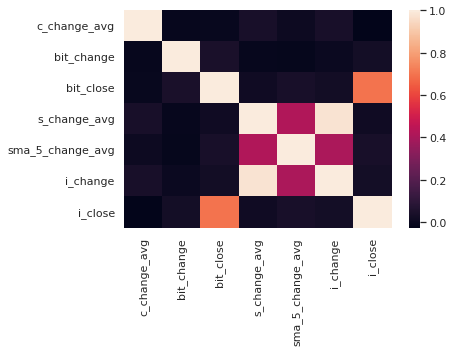

In [ ]:
# correlation
final_corr = final_df.corr()
heat_map = sns.heatmap(final_corr)

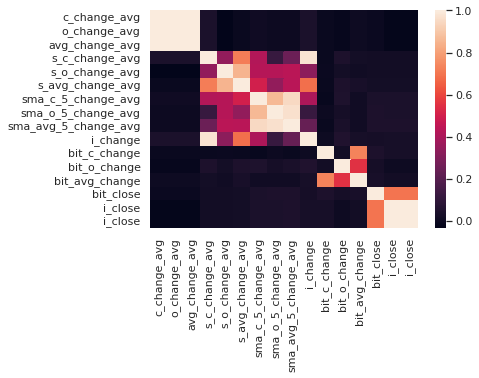

In [ ]:
#correlation for full df
final_full_corr = final_full_df.corr();
heat_map = sns.heatmap(final_full_corr)

In [ ]:
final_corr

,c_change_avg,bit_change,bit_close,s_change_avg,sma_5_change_avg,i_change,i_close
c_change_avg,1.000000,-0.007875,-0.004871,0.040540,0.006756,0.039245,-0.026001
bit_change,-0.007875,1.000000,0.045334,-0.008200,-0.013358,0.003006,0.027911
bit_close,-0.004871,0.045334,1.000000,0.015535,0.041248,0.023054,0.697205
s_change_avg,0.040540,-0.008200,0.015535,1.000000,0.421812,0.978181,0.015473
sma_5_change_avg,0.006756,-0.013358,0.041248,0.421812,1.000000,0.407886,0.041152
i_change,0.039245,0.003006,0.023054,0.978181,0.407886,1.000000,0.027494
i_close,-0.026001,0.027911,0.697205,0.015473,0.041152,0.027494,1.000000


In [ ]:
# remove unuseful columns
corr_cols = final_corr.columns.tolist()
corr_cols = corr_cols[3:]
final_corr = final_corr[corr_cols]
final_corr

,s_change_avg,sma_5_change_avg,i_change,i_close
c_change_avg,0.040540,0.006756,0.039245,-0.026001
bit_change,-0.008200,-0.013358,0.003006,0.027911
bit_close,0.015535,0.041248,0.023054,0.697205
s_change_avg,1.000000,0.421812,0.978181,0.015473
sma_5_change_avg,0.421812,1.000000,0.407886,0.041152
i_change,0.978181,0.407886,1.000000,0.027494
i_close,0.015473,0.041152,0.027494,1.000000


In [ ]:
# remove unuseful rows
final_corr_tidy = final_corr.drop(index=['s_change_avg','sma_5_change_avg','i_change','i_close'])
final_corr_tidy

,s_change_avg,sma_5_change_avg,i_change,i_close
c_change_avg,0.040540,0.006756,0.039245,-0.026001
bit_change,-0.008200,-0.013358,0.003006,0.027911
bit_close,0.015535,0.041248,0.023054,0.697205


### Observation

We observed that the closing price of bitcoin has high positive correlation with S&P500 Index (0.697205).

With such observation, we want to introduce a hypothesis where the trading strategy for S&P500 Index would be applicable to the trading of Bitcoin.



## Predictions

In this section, we will train machine learning models to predict the price movement of Crypto. Some models we will be using includes: Linear Regression, Logistic Regression, Naive-Bayes, Random Forest.
For some models, we want to see if we can train the data in a different way from what we learned in class.

In [ ]:
final_df

,c_change_avg,bit_change,bit_close,s_change_avg,sma_5_change_avg,i_change,i_close
date,,,,,,,
2013-04-29,0.089292,0.076969,144.54,0.006691,0.004577,0.007186,1593.61
2013-04-30,-0.023004,-0.038328,139.00,0.004380,0.003036,0.002485,1597.57
2013-05-01,-0.151730,-0.158345,116.99,-0.009892,0.000609,-0.009308,1582.70
2013-05-02,-0.107047,-0.100692,105.21,0.009683,0.001268,0.009408,1597.59
2013-05-03,12.778635,-0.070906,97.75,0.012610,0.004616,0.010535,1614.42
...,...,...,...,...,...,...,...
2018-02-01,-0.086016,-0.102783,9170.54,-0.002452,-0.002430,-0.000648,2821.98
2018-02-02,0.018199,-0.037052,8830.75,-0.020146,-0.008356,-0.021209,2762.13
2018-02-05,-0.188501,-0.159688,6955.27,-0.036907,-0.014138,-0.040979,2648.94


In [ ]:
from sklearn.model_selection import train_test_split

In the cell below, we create 2 kinds of labels:
First one has 4 values from -1 to 2, which is used for most models.
Second label is just 0 or 1, which is only used for linear and logistic regression

In [ ]:
## TODO: Need to separate into labels first
# Predict based on price movement. If bit coin changed positively, gives 1, vice versa.
#final_df_2 = final_df.copy()
def one_punch(row):
  if row['bit_change'] >= 0.05 and row['i_change'] >= 0.01:
    val = 2
  elif row['bit_change'] >= 0 and row['i_change'] >= 0:
    val = 1
  elif (row['bit_change'] < -0.05 and row['i_change'] < -0.01):
    val = 0
  else:
    val = -1 
  return val

def binary_labels(row):
  if row['bit_change'] >= 0 and row['i_change'] >= 0:
    val = 1
  else:
    val = 0
  return val
pd.options.mode.chained_assignment = None
final_df['bit_movement'] = final_df.apply(one_punch, axis=1)
final_df['binary_bit_movement'] = final_df.apply(binary_labels, axis=1)

#### Linear Regression Prediction 

Reference: https://towardsdatascience.com/introduction-to-linear-regression-in-python-c12a072bedf0

In [ ]:
final_df

,c_change_avg,bit_change,bit_close,s_change_avg,sma_5_change_avg,i_change,i_close,bit_movement,binary_bit_movement
date,,,,,,,,,
2013-04-29,0.089292,0.076969,144.54,0.006691,0.004577,0.007186,1593.61,1,1
2013-04-30,-0.023004,-0.038328,139.00,0.004380,0.003036,0.002485,1597.57,-1,0
2013-05-01,-0.151730,-0.158345,116.99,-0.009892,0.000609,-0.009308,1582.70,-1,0
2013-05-02,-0.107047,-0.100692,105.21,0.009683,0.001268,0.009408,1597.59,-1,0
2013-05-03,12.778635,-0.070906,97.75,0.012610,0.004616,0.010535,1614.42,-1,0
...,...,...,...,...,...,...,...,...,...
2018-02-01,-0.086016,-0.102783,9170.54,-0.002452,-0.002430,-0.000648,2821.98,-1,0
2018-02-02,0.018199,-0.037052,8830.75,-0.020146,-0.008356,-0.021209,2762.13,-1,0
2018-02-05,-0.188501,-0.159688,6955.27,-0.036907,-0.014138,-0.040979,2648.94,0,0


In [ ]:
xmean = np.mean(final_df['bit_close'])
ymean = np.mean(final_df['i_close'])
ols_df= final_df[['bit_close']]
ols_df['i_close'] = final_df['i_close']


In [ ]:
ols_df['xycov'] = (ols_df['bit_close'] - xmean) * (ols_df['i_close'] - ymean)
ols_df['xvar'] = (ols_df['bit_close'] - xmean)**2

In [ ]:
ols_df

,bit_close,i_close,xycov,xvar
date,,,,
2013-04-29,144.54,1593.61,6.225077e+05,1.602308e+06
2013-04-30,139.00,1597.57,6.201976e+05,1.616364e+06
2013-05-01,116.99,1582.70,6.501670e+05,1.672814e+06
2013-05-02,105.21,1597.59,6.366550e+05,1.703424e+06
2013-05-03,97.75,1614.42,6.182027e+05,1.722953e+06
...,...,...,...,...
2018-02-01,9170.54,2821.98,5.716061e+06,6.022035e+07
2018-02-02,8830.75,2762.13,5.021665e+06,5.506214e+07
2018-02-05,6955.27,2648.94,3.124827e+06,3.074599e+07


In [ ]:
#variables for linear regression
beta = ols_df['xycov'].sum() / ols_df['xvar'].sum()
alpha = ymean - (beta * xmean)
print(f'alpha = {alpha}')
print(f'beta = {beta}')

alpha = 1992.805218086466
beta = 0.06564676911053599


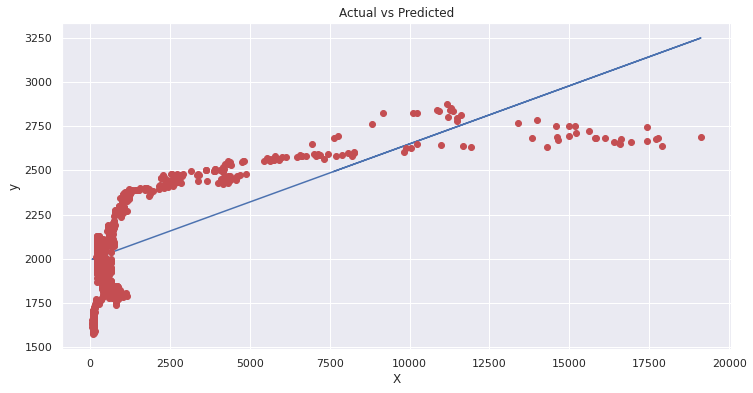

In [ ]:
# Plot regression against actual data
ypred = alpha + beta * ols_df['bit_close']
plt.figure(figsize=(12, 6))
plt.plot(ols_df['bit_close'], ypred)     # regression line
plt.plot(ols_df['bit_close'], ols_df['i_close'], 'ro')   # scatter plot showing actual data
plt.title('Actual vs Predicted')
plt.xlabel('X')
plt.ylabel('y')

plt.show()

### Observation

We observed that bitcoin's price rose sharply in a short period of time before it reached USD2500. This is mainly due to the rapid provision of crypto trading in that period. On the other hand, S&P 500 index has existed for a very long time. Therefore, the period when bitcoin's price is above USD2500 may not be useful in comparing with the price movement of S&P 500. We should only compare the data during the period when the crypto market is relatively steadier and more mature. 

As such, we removed the early period of data when bitcoin's price is above $2500. 

In [ ]:
# Drop the period where price of bitcoin is below 2500
final_df_below2500 = final_df[final_df['bit_close'] < 2500]
final_df_2 = final_df_below2500
final_df_2

,c_change_avg,bit_change,bit_close,s_change_avg,sma_5_change_avg,i_change,i_close,bit_movement,binary_bit_movement
date,,,,,,,,,
2013-04-29,0.089292,0.076969,144.54,0.006691,0.004577,0.007186,1593.61,1,1
2013-04-30,-0.023004,-0.038328,139.00,0.004380,0.003036,0.002485,1597.57,-1,0
2013-05-01,-0.151730,-0.158345,116.99,-0.009892,0.000609,-0.009308,1582.70,-1,0
2013-05-02,-0.107047,-0.100692,105.21,0.009683,0.001268,0.009408,1597.59,-1,0
2013-05-03,12.778635,-0.070906,97.75,0.012610,0.004616,0.010535,1614.42,-1,0
...,...,...,...,...,...,...,...,...,...
2017-07-13,0.073008,-0.017067,2357.90,0.002524,0.003054,0.001875,2447.83,-1,0
2017-07-14,0.110277,-0.052827,2233.34,0.004814,0.002682,0.004674,2459.27,-1,0
2017-07-17,0.234835,0.154724,2228.41,0.001417,0.002910,-0.000053,2459.14,-1,0


alpha = 1845.262187910984
beta = 0.3156733075362359


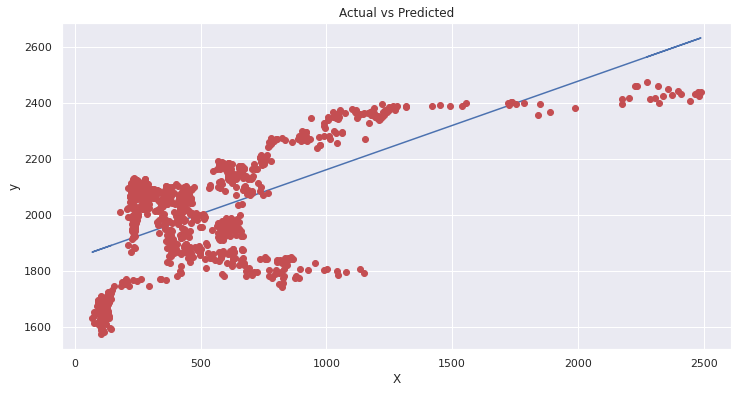

In [ ]:
xmean = np.mean(final_df_below2500['bit_close'])
ymean = np.mean(final_df_below2500['i_close'])
ols_df= final_df_below2500[['bit_close']]
ols_df['i_close'] = final_df_below2500['i_close']
ols_df['xycov'] = (ols_df['bit_close'] - xmean) * (ols_df['i_close'] - ymean)
ols_df['xvar'] = (ols_df['bit_close'] - xmean)**2
beta = ols_df['xycov'].sum() / ols_df['xvar'].sum()
alpha = ymean - (beta * xmean)
print(f'alpha = {alpha}')
print(f'beta = {beta}')
# Plot regression against actual data
ypred = alpha + beta * ols_df['bit_close']
plt.figure(figsize=(12, 6))
plt.plot(ols_df['bit_close'], ypred)     # regression line
plt.plot(ols_df['bit_close'], ols_df['i_close'], 'ro')   # scatter plot showing actual data
plt.title('Actual vs Predicted')
plt.xlabel('X')
plt.ylabel('y')

plt.show()

After looking at data from 0 USD to 2,500 USD, we find out it is looking better. However, this is still not optimal, therefore, we decided to try working on logistic regression and see if we can get a better result. 

### Logistic Regression
In this section, we will be using features: ['c_change_avg', 's_change_avg', 'sma_5_change_avg', 'i_change', 'i_close']. As said above, we will use binary_bit_movement as the label, which has only 0 and 1 as the values. 1 represents rise in price for crypto, and 0 means a drop in price compared the the day before.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('ml-project').getOrCreate()

In [ ]:
%load_ext sparkmagic.magics

In [ ]:
#graph section
import networkx as nx
# SQLite RDBMS
import sqlite3
# Parallel processing
# import swifter
import pandas as pd
# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop3.2'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [ ]:
#set up Spark
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)


In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

In [ ]:
movement_sdf = spark.createDataFrame(final_df)

In [ ]:
movement_sdf.show()

+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-------+------------+-------------------+
|        c_change_avg|          bit_change|bit_close|        s_change_avg|    sma_5_change_avg|            i_change|i_close|bit_movement|binary_bit_movement|
+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-------+------------+-------------------+
| 0.08929198769891526| 0.07696892928991872|   144.54|0.006691130976937...|0.004576515361128176|0.007186014763878923|1593.61|           1|                  1|
|-0.02300420817796...| -0.0383284903832849|    139.0|0.004379732864296629|0.003036186828234...|0.002484924165887...|1597.57|          -1|                  0|
|-0.15173023935782598|-0.15834532374100718|   116.99|-0.00989200553001519|6.085895582368372E-4|-0.00930788635239...| 1582.7|          -1|                  0|
|-0.10704707378669005|-0.10069236686896321|   105.21

In [ ]:
columns_to_use = movement_sdf.columns
columns_to_use.remove('bit_movement')
columns_to_use.remove('binary_bit_movement')
columns_to_use.remove('bit_close')
columns_to_use.remove('bit_change')
columns_to_use

['c_change_avg', 's_change_avg', 'sma_5_change_avg', 'i_change', 'i_close']

In [ ]:
# Create pipieline
from pyspark.ml import Pipeline
assembler = VectorAssembler(
    inputCols = columns_to_use,
    outputCol='features')
pipe = Pipeline(stages=[assembler])
pipe_model = pipe.fit(movement_sdf)
modified_data_sdf = pipe_model.transform(movement_sdf)

In [ ]:
train_sdf, test_sdf = modified_data_sdf.randomSplit([0.8,0.2], 24)

In [ ]:
# Logistic regression
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'binary_bit_movement', maxIter=5)
clfModel = lr.fit(train_sdf)

In [ ]:
training_summary = clfModel.summary

In [ ]:
# prediction and evaluation 
predictions = clfModel.transform(test_sdf)

# training accuracy
accuracy = training_summary.accuracy

accuracy

0.7295918367346939

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [ ]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='bit_movement')
# area under curve
test_predictions_log = evaluator.evaluate(predictions, {evaluator.metricName:"areaUnderROC"})

In [ ]:
test_predictions_log

0.5460947503201025

## Other kinds of machine learning

So far, the logistic regression is giving us an accuracy of 73%. But we are going to find out if other models are even more effective than logistic regression in predictions.

In [ ]:
#our features to train and test with
#features = final_df[['s_change_avg','sma_5_change_avg','i_change','i_close', 'c_change_avg', 'bit_change', 'bit_close', 's_change_avg']].copy()
features = final_df[['s_change_avg','sma_5_change_avg','i_change','i_close', 'c_change_avg', 's_change_avg']].copy()
#features = final_df[['i_change']].copy()
labels = final_df[['bit_movement']].copy()

In [ ]:
# 80-20 train-test split
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
features

,s_change_avg,sma_5_change_avg,i_change,i_close,c_change_avg,s_change_avg
date,,,,,,
2013-04-29,0.006691,0.004577,0.007186,1593.61,0.089292,0.006691
2013-04-30,0.004380,0.003036,0.002485,1597.57,-0.023004,0.004380
2013-05-01,-0.009892,0.000609,-0.009308,1582.70,-0.151730,-0.009892
2013-05-02,0.009683,0.001268,0.009408,1597.59,-0.107047,0.009683
2013-05-03,0.012610,0.004616,0.010535,1614.42,12.778635,0.012610
...,...,...,...,...,...,...
2018-02-01,-0.002452,-0.002430,-0.000648,2821.98,-0.086016,-0.002452
2018-02-02,-0.020146,-0.008356,-0.021209,2762.13,0.018199,-0.020146
2018-02-05,-0.036907,-0.014138,-0.040979,2648.94,-0.188501,-0.036907


#### Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
#fit, train, and test Naive Bayes Classifier
clf = GaussianNB()
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
GaussianNB()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [ ]:
#Accuracy for Naive Bayes Classifier
naive_bayes_acc= clf.score(x_test,y_test)
print("Test accuracy: ", naive_bayes_acc *100, "%")

Test accuracy:  28.63070539419087 %


The result went out really bad, we only have an accuracy of 29%. This model has the worse accuracy out of all machine learning models.

# Dimensionality Reduction with PCA and then do Random Forest
For Random Forest, we decided to feed in different data sets and see if it impacts the accuracy. This part will be different from all previous machine learning models as we want to also consider the human perspective and see if human intelligence + machine learning can perform better than simply machine learning.
We will do 2 different kinds of random forest classifiers: partial features and full features.

Partial features: When we are doing this project, we did a lot of research on stock markets and see what are some of the important factors to take into consideration when doing predictions. After research, we found a couple of features that have the biggest impact on stock price fluctuation. Therefore, for the first random forest classifier, we will only feed machine features we think that is necessary: ['s_change_avg','sma_5_change_avg','i_change','i_close']

Full features: For full features, we will trust the machine and feed in all the features we have. In this case, human intelligence will not be taken into consideration, and we will let the machine decide what features are important to make decisions.

Let's see who's going to end up with higher accuracy!


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Model with partial features

Traditionally, only closing price is used to feed machine learning in stock trading strategies. So we will drop features that we think are unnecessary. Then, we will run PCA to get the final features.

In [ ]:
features = final_df[['s_change_avg','sma_5_change_avg','i_change','i_close']].copy()
labels = final_df[['bit_movement']].copy()


In [ ]:
# 80-20 train-test split
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

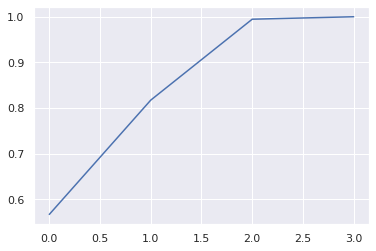

In [ ]:
#find how many components to use on partial features
scaled = StandardScaler()
x_train_scaled = scaled.fit_transform(x_train)
pca = PCA(n_components=x_train_scaled.shape[1])
pca_x_train = pca.fit_transform(x_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [ ]:
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[0.56662702 0.25057047 0.17739574 0.00540677]


In [ ]:
#PCA on partial features
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_scaled = scaled.transform(x_test)
x_test = pca.transform(x_test_scaled)

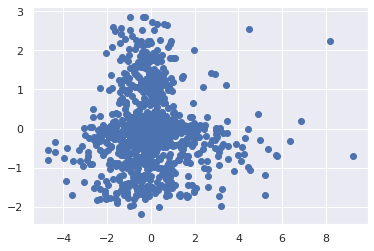

In [ ]:
# visualize 2 components of PCA
pca_plot = PCA(n_components=2)
comp = pca_plot.fit_transform(x_train_pca)
data = np.transpose(np.array(comp))
plt.scatter(data[0][0:5000], data[1][0:5000])

### Partial features for Random Forest
After running PCA, we now have the features we want, we will do supervised machine learning and see if the accuracy can increase.

In [ ]:
#helper function to print out best parameters
def print_best_params(results):
    print('best_params: {}\n'.format(results.best_params_))

In [ ]:
#create random forest classifier, fit and train it on data
param_grid = {
    'n_estimators': [40, 60],
    'max_depth': [2] # 8 is better
}
forest = RandomForestClassifier(n_estimators = 10, max_depth=2)
forest.fit(x_train_pca,y_train)
forest_predict = forest.predict(x_test) 
rf_cv = GridSearchCV(estimator=forest, cv= 5, param_grid=param_grid)
rf_cv.fit(x_train_pca,y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/loc

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=2, n_estimators=10),
             param_grid={'max_depth': [2], 'n_estimators': [40, 60]})

In [ ]:
print_best_params(rf_cv) ## best params are

best_params: {'max_depth': 2, 'n_estimators': 40}



In [ ]:
#test accuracy for random forest classifier with partial features
test_accuracy = forest.score(x_test, y_test)
print("Test accuracy: ", test_accuracy *100, "%")

Test accuracy:  70.53941908713693 %


By using partial features for Random Forest, we only obtained **around 70% accuracy**. 

This may mean the traditional way of only using 'close' price as input may not be sufficient. 

Now we will be including all features.

## Model with full features
Everything we do for full features will be the same as partial features above except we use all the columns.



In [ ]:
final_full_df

,c_change_avg,o_change_avg,avg_change_avg,s_c_change_avg,s_o_change_avg,s_avg_change_avg,sma_c_5_change_avg,sma_o_5_change_avg,sma_avg_5_change_avg,i_change,bit_c_change,bit_o_change,bit_avg_change,bit_close,i_close,i_close
date,,,,,,,,,,,,,,,,
2013-04-29,0.089292,0.002578,0.055983,0.006691,0.000183,0.003544,0.004577,0.004228,0.004875,0.007186,0.076969,-0.006356,0.050022,144.54,1593.61,1593.61
2013-04-30,-0.023004,0.081839,0.036200,0.004380,0.003017,0.002060,0.003036,0.003348,0.002987,0.002485,-0.038328,0.071110,-0.001812,139.00,1597.57,1597.57
2013-05-01,-0.151730,-0.021604,-0.117243,-0.009892,0.001493,-0.000921,0.000609,0.002252,0.001656,-0.009308,-0.158345,-0.034722,-0.118763,116.99,1582.70,1582.70
2013-05-02,-0.107047,-0.150841,-0.113502,0.009683,-0.004234,0.000945,0.001268,0.000381,0.000517,0.009408,-0.100692,-0.162734,-0.120068,105.21,1597.59,1597.59
2013-05-03,12.778635,8.346717,10.403560,0.012610,0.016169,0.015955,0.004616,0.003246,0.004268,0.010535,-0.070906,-0.087042,-0.140674,97.75,1614.42,1614.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,-0.086016,0.059201,-0.015102,-0.002452,-0.007164,-0.004237,-0.002430,-0.003473,-0.002614,-0.000648,-0.102783,0.012772,-0.052480,9170.54,2821.98,2821.98
2018-02-02,0.018199,-0.064525,-0.075688,-0.020146,-0.005345,-0.012019,-0.008356,-0.004357,-0.005610,-0.021209,-0.037052,-0.106964,-0.113204,8830.75,2762.13,2762.13
2018-02-05,-0.188501,-0.108607,-0.155610,-0.036907,-0.020424,-0.025678,-0.014138,-0.009224,-0.011043,-0.040979,-0.159688,-0.098648,-0.129250,6955.27,2648.94,2648.94


In [ ]:
# features = final_df[['s_change_avg','sma_5_change_avg','i_change','i_close', 'c_change_avg', 'bit_change', 'bit_close', 's_change_avg']].copy()
features = final_full_df[['c_change_avg',	'o_change_avg',	'avg_change_avg', 's_c_change_avg','s_o_change_avg',	's_avg_change_avg','sma_c_5_change_avg',	'sma_o_5_change_avg',	'sma_avg_5_change_avg','i_change','i_close']].copy()
labels = final_df[['bit_movement']].copy()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

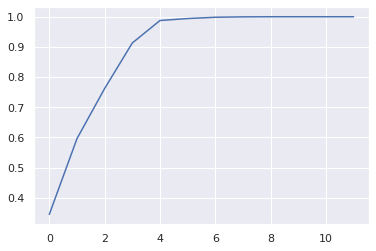

In [ ]:
#find how many components to use on full features
scaled = StandardScaler()
x_train_scaled = scaled.fit_transform(x_train)
pca = PCA(n_components=x_train_scaled.shape[1])
pca_x_train = pca.fit_transform(x_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [ ]:
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[3.44655430e-01 2.51164522e-01 1.66234744e-01 1.50974027e-01
 7.44518840e-02 6.53846819e-03 4.27664224e-03 1.31456249e-03
 3.89576956e-04 1.41105694e-07 2.17058342e-09 1.14098886e-32]


In [ ]:
#5 gave us the optimal components so we perform PCA with 5 components
pca = PCA(n_components=5)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_scaled = scaled.transform(x_test)
x_test = pca.transform(x_test_scaled)

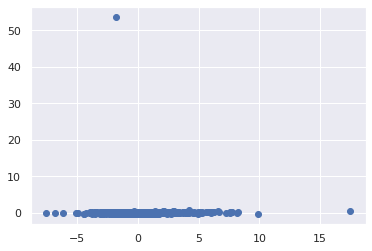

In [ ]:
# visualize 2 components of PCA
pca_plot = PCA(n_components=5)
comp = pca_plot.fit_transform(x_train_pca)
data = np.transpose(np.array(comp))
plt.scatter(data[0][0:5000], data[1][0:5000])

#### Random Forest
Now we have done PCA with ful features, we will do supervised learning and see if the result is better or worse than partial features.

In [ ]:
def print_best_params(results):
    print('best_params: {}\n'.format(results.best_params_))

In [ ]:
#train and perform a random forest classifier on our full featured data
forest = RandomForestClassifier(n_estimators = 40, max_depth=8)
forest.fit(x_train_pca,y_train)
forest_predict = forest.predict(x_test) 
rf_cv = GridSearchCV(estimator=forest, cv= 5, param_grid=param_grid)
rf_cv.fit(x_train_pca,y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example us

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=8, n_estimators=40),
             param_grid={'max_depth': [2], 'n_estimators': [40, 60]})

In [ ]:
print_best_params(rf_cv) ## best params are

best_params: {'max_depth': 2, 'n_estimators': 60}



In [ ]:
test_accuracy = forest.score(x_test, y_test)
print("Test accuracy: ", test_accuracy *100, "%")

Test accuracy:  72.19917012448133 %


##So Far
After running partial features and full features, we are both getting an accuracy around 70%, which means human intelligence is not making a big impact, or it can be simply that not enough of research is done. We are still not getting the accuracy we want, so we continue to see if we can have a better approach to make use of random forest in predicting crypto prices.

#Focus on specific time frame
We have learned about time-varying data in class, and we wonder if it is time that is causing low accuracy. We will now be targeting a specific year and do machine learning on that year. We picked 2017 because the data set only has data from 2013 to 2018 November, which we are missing December from 2018. We are choosing the most recent year because crypto starts getting stable and mature in recent years compared to when first released. We believe that having stable data can make the training and prediction more accurate.

In [ ]:
df_2017 = final_full_df.copy()
df_2017.reset_index(inplace=True)

In [ ]:
#transform dates into string
df_2017 = df_2017.astype({"date": str}, errors='raise') 

In [ ]:
#filter dataframe for the year 2017
df_2017 = df_2017 [df_2017 ['date'].str.contains("2017")]

In [ ]:
df_2017

,date,c_change_avg,o_change_avg,avg_change_avg,s_c_change_avg,s_o_change_avg,s_avg_change_avg,sma_c_5_change_avg,sma_o_5_change_avg,sma_avg_5_change_avg,i_change,bit_c_change,bit_o_change,bit_avg_change,bit_close,i_close,i_close
928,2017-01-03,0.070826,0.042982,0.040476,0.007950,0.001424,0.004309,-0.000568,-0.000369,-0.000582,0.008487,0.021620,0.023012,0.018535,1043.84,2257.83,2257.83
929,2017-01-04,10.047784,10.562328,8.357306,0.008729,0.002049,0.006502,0.000546,-0.000659,-0.000159,0.005722,0.106233,0.022318,0.066874,1154.73,2270.75,2270.75
930,2017-01-05,-0.101398,0.098959,-0.049332,-0.003210,0.004572,-0.000430,0.001906,-0.000328,0.000610,-0.000771,-0.122410,0.107555,-0.046419,1013.38,2269.00,2269.00
931,2017-01-06,0.003166,-0.100884,-0.031311,0.003074,0.000370,0.002039,0.002330,0.001887,0.001947,0.003517,-0.109712,-0.123183,-0.081260,902.20,2276.98,2276.98
932,2017-01-09,0.058607,0.052183,0.037550,-0.005395,0.000999,-0.001545,0.001871,0.001568,0.001868,-0.003549,-0.009186,0.005583,-0.019929,902.83,2268.90,2268.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,2017-12-22,-0.079430,0.073392,-0.105589,0.000768,0.000350,-0.000470,0.001331,0.001809,0.001485,-0.000458,-0.124730,-0.044729,-0.155999,13831.80,2683.34,2683.34
1175,2017-12-26,5.218773,3.404918,4.109085,0.001239,0.000535,0.002124,0.000163,0.000046,0.000198,-0.001058,0.147805,0.002908,0.087305,16099.80,2680.50,2680.50
1176,2017-12-27,0.116710,0.153819,0.139874,0.000094,0.002638,0.000302,0.000786,0.000043,0.000258,0.000791,-0.016230,0.151525,0.051003,15838.50,2682.62,2682.62
1177,2017-12-28,8.357501,7.961286,8.084832,0.002354,0.000402,-0.000088,0.001302,0.000413,0.000531,0.001834,-0.077785,-0.018523,-0.069262,14606.50,2687.54,2687.54


In [ ]:
#use all features for this model
features = df_2017[['c_change_avg',	'o_change_avg',	'avg_change_avg', 's_c_change_avg','s_o_change_avg',	's_avg_change_avg','sma_c_5_change_avg',	'sma_o_5_change_avg',	'sma_avg_5_change_avg','i_change','i_close']].copy()
temp = final_df[['bit_movement']].copy()
temp.reset_index(inplace=True)
temp = temp.astype({"date": str}, errors='raise') 
labels = temp [temp ['date'].str.contains("2017")]

In [ ]:
labels = labels[['bit_movement']].copy()

In [ ]:
features

,c_change_avg,o_change_avg,avg_change_avg,s_c_change_avg,s_o_change_avg,s_avg_change_avg,sma_c_5_change_avg,sma_o_5_change_avg,sma_avg_5_change_avg,i_change,i_close,i_close
928,0.070826,0.042982,0.040476,0.007950,0.001424,0.004309,-0.000568,-0.000369,-0.000582,0.008487,2257.83,2257.83
929,10.047784,10.562328,8.357306,0.008729,0.002049,0.006502,0.000546,-0.000659,-0.000159,0.005722,2270.75,2270.75
930,-0.101398,0.098959,-0.049332,-0.003210,0.004572,-0.000430,0.001906,-0.000328,0.000610,-0.000771,2269.00,2269.00
931,0.003166,-0.100884,-0.031311,0.003074,0.000370,0.002039,0.002330,0.001887,0.001947,0.003517,2276.98,2276.98
932,0.058607,0.052183,0.037550,-0.005395,0.000999,-0.001545,0.001871,0.001568,0.001868,-0.003549,2268.90,2268.90
...,...,...,...,...,...,...,...,...,...,...,...,...
1174,-0.079430,0.073392,-0.105589,0.000768,0.000350,-0.000470,0.001331,0.001809,0.001485,-0.000458,2683.34,2683.34
1175,5.218773,3.404918,4.109085,0.001239,0.000535,0.002124,0.000163,0.000046,0.000198,-0.001058,2680.50,2680.50
1176,0.116710,0.153819,0.139874,0.000094,0.002638,0.000302,0.000786,0.000043,0.000258,0.000791,2682.62,2682.62
1177,8.357501,7.961286,8.084832,0.002354,0.000402,-0.000088,0.001302,0.000413,0.000531,0.001834,2687.54,2687.54


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

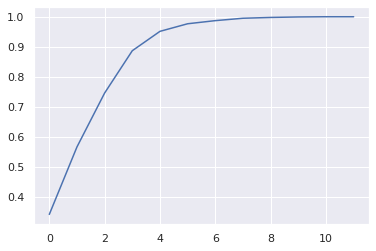

In [ ]:
#train PCA on our model
scaled = StandardScaler()
x_train_scaled = scaled.fit_transform(x_train)
pca = PCA(n_components = x_train_scaled.shape[1])
pca_x_train = pca.fit_transform(x_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [ ]:
#5 is the ideal number of components so we perform PCA with 5 components
pca = PCA(n_components=8)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_scaled = scaled.transform(x_test)
x_test = pca.transform(x_test_scaled)

In [ ]:

forest = RandomForestClassifier(random_state=42)
forest.fit(x_train_pca,y_train)
forest_predict = forest.predict(x_test) 
rf_cv = GridSearchCV(estimator=forest, cv= 5, param_grid=param_grid)
rf_cv.fit(x_train_pca,y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example us

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2], 'n_estimators': [40, 60]})

In [ ]:
test_accuracy = forest.score(x_test, y_test)
print("Test accuracy: ", test_accuracy *100, "%")

Test accuracy:  72.54901960784314 %


The accuracy did not become sigfinicantly better.

# **4. Conclusion**

1) Stock price doesn’t provide good features for machine learning in predicting the price movement for Bitcoin and cryptocurrencies. Overall, the accuracy of our prediction model lies around 70%. 

2) Traditional machine learning algorithms for stocks should not be used directly on predicting the price movement of cryptocurrencies. The difference could be explained by the much higher speculative elements embedded in cryptocurrencies.

3) Logistic Regression is the best model for predicting cryptocurrency price movement, though it is not significantly better than other models.
